In [1]:
!pip install /user-home/py_packages/catboost-0.6.3-cp27-none-manylinux1_x86_64.whl

!pip install /user-home/py_packages/mlxtend-0.11.0-py2.py3-none-any.whl

In [2]:
import sys 
sys.path.append('/user-home/1014/code')
from eval_functions import *
from pdp import *
from mlxtend.classifier import StackingCVClassifier
%matplotlib inline

import matplotlib.pyplot as plt

from __future__ import division
import numpy as np
np.random.seed(198908)
import pandas as pd

from sklearn.model_selection import cross_val_score,cross_val_predict
pd.set_option("display.max_columns",999)
from catboost import CatBoostClassifier,CatBoostRegressor,cv

import os
os.environ["JOBLIB_TEMP_FOLDER"] = "/tmp"


import xgboost as xgb
import xgbfir
from sklearn.metrics import roc_auc_score, r2_score, make_scorer
from sklearn.model_selection import PredefinedSplit,  cross_val_predict, GridSearchCV, StratifiedKFold, train_test_split, KFold , RandomizedSearchCV

from sklearn.externals import joblib

from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb 

from sklearn.feature_selection import SelectKBest, chi2

from pyearth  import Earth
from xgboost import XGBRegressor


import patsy
from patsy import dmatrix, build_design_matrices

from sklearn.linear_model import LogisticRegressionCV

def plot_single_var_response(X,var_name, response_name, bins):
    X['decile']=(bins)-(pd.qcut(X[var_name],bins,labels=False,duplicates='drop'))
    bin_toPlot=X.groupby('decile')[response_name].mean()
    fig, ax = plt.subplots()
    ax.plot(bin_toPlot)
    ax.set_xlabel("Bin")
    ax.set_ylabel("Average Target")
    ax.legend()




def oversample_2class(x,y,prop,seed=0,save_msk_path=None, shuffle=True):
    
    y_pos=y.loc[(y.values).flatten()==1]
    x_pos =x.loc[(y.values).flatten()==1,:]
    
    nb_pos=y_pos.shape[0]
    nb_neg = (nb_pos / prop) - nb_pos
    
    ttl_neg=x.loc[(y.values).flatten()==0,:]
    np.random.seed(seed)
    indx_msk=np.random.choice(a=ttl_neg.shape[0], size=int(nb_neg),replace = False)
    
    sampled_negx=x.iloc[indx_msk,:]
    sampled_negy=y.iloc[indx_msk]
    
    finalx_df=pd.concat([x_pos,sampled_negx],axis=0)
    finaly_df=pd.concat([y_pos,sampled_negy],axis=0)
    
    
    if save_msk_path != None:
        joblib.dump(indx_msk,save_msk_path)
        
    
    if shuffle:
        indx_perm=np.random.permutation(finalx_df.shape[0])
        finalx_df=finalx_df.iloc[indx_perm,:]
        finaly_df=finaly_df.iloc[indx_perm,:]
        
        
        
    return(finalx_df,finaly_df)



from scipy.stats import randint as sp_randint, uniform


In [3]:
full=pd.read_csv('/user-home/1014/checking_models/response_rebuild/high_bal_response/jul_jan_high_bal.txt', na_values=['.', 'null'], dtype={'block_group':np.object, 'census_tract': np.object})

scores=pd.read_csv('/user-home/1014/checking_models/response_rebuild/scores.txt', na_values=['.', 'null'])
full=pd.merge(full,scores,how='left',left_on=['CAMPAIGN','Person_Seq_No_1_183'], right_on=['campaign','Person_Seq_No_1_183'])

add_tsp=pd.read_csv('/user-home/1014/checking_models/response_rebuild/additionaltsp.txt', na_values=['.', ' ','','null'])
full=pd.merge(full,add_tsp,how='left',left_on=['CAMPAIGN','Person_Seq_No_1_183','date_key_link'], right_on=['CAMPAIGN','Person_Seq_No_1_183','Date_key_link'])

/opt/conda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (5,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,2,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:

# Advantage_Target_Income_20_876   
d1={1:1,
2:2,
3:3,
4:4,
5:5,
6:6,
7:7,
8:8,
9:9,
'A':10,
'B':11,
'C':12,
'D':13
}


d2={'Y':1, 'N':0}

#target value score
d3={'A1':1.0,
'A2':2.0,
'B1':3.0,
'B2':4.0,
'C1':5.0,
'C2':6.0,
'D1':7.0,
'D2':8.0,
'D3':9.0
}

#merit score,TriggerVal_ValueScore_1060
d4={'A1':1.0,
'A2':2.0,
'B1':3.0,
'B2':4.0,
'C1':5.0,
'C2':6.0,
'D1':7.0,
'D2':8.0,
'D3':9.0,
'E1':10.0,
'E2':11.0,
'E3':12.0
}


d5={
'A':'10',
'B':'11',
'C':'12',
'D':'13'
}

d6={
'N':'0',
'D':'1',
'I':'-1',
}

d7={
'A':1.0,
    'B':2.0,
    'C':3.0,
    'D':4.0,
    'E':5.0,
    'F':6.0,
    'G':7.0,
    'H':8.0,
    'I':9.0,
    'J':10.0,
    'K':11.0,
    'L':12.0,
    'M':13.0,
    'N':14.0,
    'O':15.0,
    'P':16.0,
    'Q':17.0,
    'Z':18.0
            
}

full['TriggerVal_Home_Market_Valu_1002']=full.TriggerVal_Home_Market_Valu_1002.map(d7)



full['Credit_Card_Trigger_978']=full.Credit_Card_Trigger_978.fillna('N').map(d6)
full['Home_Market_Value_Trigger_1001']=full.Home_Market_Value_Trigger_1001.fillna('N').map(d6)
full['Income_Trigger_1009']=full.Income_Trigger_1009.fillna('N').map(d6)
full['ValueScore_Trigger_1059']=full.ValueScore_Trigger_1059.fillna('N').map(d6)
full['Niche_Switch_Trigger_1068']=full.Niche_Switch_Trigger_1068.fillna('N').map(d6)


#update when dict is not exhuastive (and is inplace!)
full['TriggerVal_Income_1010'].update(full['TriggerVal_Income_1010'].map(d5))
full['TriggerVal_Income_1010']=full['TriggerVal_Income_1010'].fillna('0').astype(float)





full['TriggerVal_ValueScore_1060']=full['TriggerVal_ValueScore_1060'].map(d4)  


full['Merit_Score_1881']=full['Merit_Score_1881'].map(d4)  

full['Mobility_Score_1878']=full['Mobility_Score_1878'].map(d4) 

full['Target_ValueScore_20_All_614']=full['Target_ValueScore_20_All_614'].map(d3)  
full['Target_ValueScore_20_Aut_616']=full['Target_ValueScore_20_Aut_616'].map(d3) 
full['Target_ValueScore_20_Ban_618']=full['Target_ValueScore_20_Ban_618'].map(d3)  
full['Target_ValueScore_20_Ret_620']=full['Target_ValueScore_20_Ret_620'].map(d3)  

full['Investments_and_Insurance_739'].fillna('N',inplace=True)
full['Investments_and_Insurance_744'].fillna('N',inplace=True)
full['Investments_and_Insurance_739']= full['Investments_and_Insurance_739'].map(d2)   
full['Investments_and_Insurance_744']= full['Investments_and_Insurance_744'].map(d2)  

full['Target_Home_Market_Value_894_v']=full.Target_Home_Market_Value_894.str[0:4].fillna(0).astype(float)  
full['Advantage_Target_Income_20_876']=full['Advantage_Target_Income_20_876'].map(d1)  


full['Current_Loan_to_Value_890']=full['Current_Loan_to_Value_890'].fillna(0).astype(float) 
full['Available_home_equity_in_th_899']=full['Available_home_equity_in_th_899'].fillna(0).astype(float)  
full['Advantage_Length_of_Residen_823']=full['Advantage_Length_of_Residen_823'].fillna(0).astype(float)  
full['Target_PreMover_20_Model_879']=full['Target_PreMover_20_Model_879'].fillna(0).astype(float)  

full['Gold_Wallets_1100'].fillna('N',inplace=True)
full['Silver_Wallets_1102'].fillna('N',inplace=True)
full['Platinum_Wallets_1101'].fillna('N',inplace=True)

full['Gold_Wallets_1100']= full['Gold_Wallets_1100'].map(d2)
full['Silver_Wallets_1102']= full['Silver_Wallets_1102'].map(d2) 
full['Platinum_Wallets_1101']= full['Platinum_Wallets_1101'].map(d2)   

full['Liquid_Resources_1093']=full['Liquid_Resources_1093'].astype(float)  
full['Wealth_Resources_1089']=full['Wealth_Resources_1089'].astype(float)  
full['Investment_Resources_1091']=full['Investment_Resources_1091'].astype(float)  


full['income_diff']=full['Advantage_Target_Income_20_876']-full['TriggerVal_Income_1010']

full=full.drop(['Target_Home_Market_Value_894'],axis=1)



full['MDM_household_Share_BG_ixi']=full['MDM_household_Share_BG'] / full['total']
full['PEN_CHECK']=full['SUM_CHECKING_IND_BG'] / full['total_ixi_check_custs']
full['peraddress_53']=full['sum_fifth_third'] / full['addresses_CT']
full['peraddress_bc']=full['total_bankingcenters'] / full['addresses_CT']
full['checking_pen_53_MA_Custs']=full['checking_MA']/full['MA']
full['checking_pen_53_MA_Custs_BG']=full['checking_MA_BG']/full['MA_BG']


full['DMA_602']=np.where(full.DMA_176.values ==602,1,0)
full['DMA_539']=np.where(full.DMA_176.values ==539,1,0)
full['DMA_505']=np.where(full.DMA_176.values ==505,1,0)
full['DMA_510']=np.where(full.DMA_176.values ==510,1,0)
full['DMA_524']=np.where(full.DMA_176.values ==524,1,0)
full['DMA_534']=np.where(full.DMA_176.values ==534,1,0)
full['DMA_517']=np.where(full.DMA_176.values ==517,1,0)
full['DMA_535']=np.where(full.DMA_176.values ==535,1,0)
full['DMA_528']=np.where(full.DMA_176.values ==528,1,0)
full['DMA_515']=np.where(full.DMA_176.values ==515,1,0)
full['DMA_527']=np.where(full.DMA_176.values ==527,1,0)
full['DMA_563']=np.where(full.DMA_176.values ==563,1,0)
full['DMA_659']=np.where(full.DMA_176.values ==659,1,0)
full['DMA_571']=np.where(full.DMA_176.values ==571,1,0)
full['DMA_529']=np.where(full.DMA_176.values ==529,1,0)
full['DMA_542']=np.where(full.DMA_176.values ==542,1,0)
full['DMA_561']=np.where(full.DMA_176.values ==561,1,0)
full['DMA_548']=np.where(full.DMA_176.values ==548,1,0)
full['DMA_513']=np.where(full.DMA_176.values ==513,1,0)
full['DMA_547']=np.where(full.DMA_176.values ==547,1,0)
full['DMA_560']=np.where(full.DMA_176.values ==560,1,0)


full['pred']= full.pred_y

In [5]:
#remove Jan 18
full=full.loc[full.CAMPAIGN != 'JAN18',:]

In [8]:
pd.DataFrame(full.columns,columns=['column']).to_csv('/user-home/1014/checking_models/response_rebuild/juloct_cols.csv')

In [9]:
#March

march=pd.read_csv('/user-home/1014/checking_models/response_rebuild/MAR_18_checking_model_data.txt')

march['DMA_602']=np.where(march.DMA_176.values ==602,1,0)
march['DMA_539']=np.where(march.DMA_176.values ==539,1,0)
march['DMA_505']=np.where(march.DMA_176.values ==505,1,0)
march['DMA_510']=np.where(march.DMA_176.values ==510,1,0)
march['DMA_524']=np.where(march.DMA_176.values ==524,1,0)
march['DMA_534']=np.where(march.DMA_176.values ==534,1,0)
march['DMA_517']=np.where(march.DMA_176.values ==517,1,0)
march['DMA_535']=np.where(march.DMA_176.values ==535,1,0)
march['DMA_528']=np.where(march.DMA_176.values ==528,1,0)
march['DMA_515']=np.where(march.DMA_176.values ==515,1,0)
march['DMA_527']=np.where(march.DMA_176.values ==527,1,0)
march['DMA_563']=np.where(march.DMA_176.values ==563,1,0)
march['DMA_659']=np.where(march.DMA_176.values ==659,1,0)
march['DMA_571']=np.where(march.DMA_176.values ==571,1,0)
march['DMA_529']=np.where(march.DMA_176.values ==529,1,0)
march['DMA_542']=np.where(march.DMA_176.values ==542,1,0)
march['DMA_561']=np.where(march.DMA_176.values ==561,1,0)
march['DMA_548']=np.where(march.DMA_176.values ==548,1,0)
march['DMA_513']=np.where(march.DMA_176.values ==513,1,0)
march['DMA_547']=np.where(march.DMA_176.values ==547,1,0)
march['DMA_560']=np.where(march.DMA_176.values ==560,1,0)


# Advantage_Target_Income_20_876   
d1={1:1,
2:2,
3:3,
4:4,
5:5,
6:6,
7:7,
8:8,
9:9,
'A':10,
'B':11,
'C':12,
'D':13
}


d2={'Y':1, 'N':0}

#target value score
d3={'A1':1.0,
'A2':2.0,
'B1':3.0,
'B2':4.0,
'C1':5.0,
'C2':6.0,
'D1':7.0,
'D2':8.0,
'D3':9.0
}

#merit score,TriggerVal_ValueScore_1060
d4={'A1':1.0,
'A2':2.0,
'B1':3.0,
'B2':4.0,
'C1':5.0,
'C2':6.0,
'D1':7.0,
'D2':8.0,
'D3':9.0,
'E1':10.0,
'E2':11.0,
'E3':12.0
}


d5={
'A':'10',
'B':'11',
'C':'12',
'D':'13'
}

d6={
'N':'0',
'D':'1',
'I':'-1',
}

d7={
'A':1.0,
    'B':2.0,
    'C':3.0,
    'D':4.0,
    'E':5.0,
    'F':6.0,
    'G':7.0,
    'H':8.0,
    'I':9.0,
    'J':10.0,
    'K':11.0,
    'L':12.0,
    'M':13.0,
    'N':14.0,
    'O':15.0,
    'P':16.0,
    'Q':17.0,
    'Z':18.0
            
}

march['TriggerVal_Home_Market_Valu_1002']=march.TriggerVal_Home_Market_Valu_1002.map(d7)



march['Credit_Card_Trigger_978']=march.Credit_Card_Trigger_978.fillna('N').map(d6)
march['Home_Market_Value_Trigger_1001']=march.Home_Market_Value_Trigger_1001.fillna('N').map(d6)
march['Income_Trigger_1009']=march.Income_Trigger_1009.fillna('N').map(d6)
march['ValueScore_Trigger_1059']=march.ValueScore_Trigger_1059.fillna('N').map(d6)
march['Niche_Switch_Trigger_1068']=march.Niche_Switch_Trigger_1068.fillna('N').map(d6)


#update when dict is not exhuastive (and is inplace!)
march['TriggerVal_Income_1010'].update(march['TriggerVal_Income_1010'].map(d5))
march['TriggerVal_Income_1010']=march['TriggerVal_Income_1010'].fillna('0').astype(float)





march['TriggerVal_ValueScore_1060']=march['TriggerVal_ValueScore_1060'].map(d4)  


march['Merit_Score_1881']=march['Merit_Score_1881'].map(d4)  

march['Mobility_Score_1878']=march['Mobility_Score_1878'].map(d4) 

march['Target_ValueScore_20_All_614']=march['Target_ValueScore_20_All_614'].map(d3)  
march['Target_ValueScore_20_Aut_616']=march['Target_ValueScore_20_Aut_616'].map(d3) 
march['Target_ValueScore_20_Ban_618']=march['Target_ValueScore_20_Ban_618'].map(d3)  
march['Target_ValueScore_20_Ret_620']=march['Target_ValueScore_20_Ret_620'].map(d3)  

march['Investments_and_Insurance_739'].fillna('N',inplace=True)
march['Investments_and_Insurance_744'].fillna('N',inplace=True)
march['Investments_and_Insurance_739']= march['Investments_and_Insurance_739'].map(d2)   
march['Investments_and_Insurance_744']= march['Investments_and_Insurance_744'].map(d2)  

march['Target_Home_Market_Value_894_v']=march.Target_Home_Market_Value_894.str[0:4].fillna(0).astype(float)  
march['Advantage_Target_Income_20_876']=march['Advantage_Target_Income_20_876'].map(d1)  


march['Current_Loan_to_Value_890']=march['Current_Loan_to_Value_890'].fillna(0).astype(float) 
march['Available_home_equity_in_th_899']=march['Available_home_equity_in_th_899'].fillna(0).astype(float)  
march['Advantage_Length_of_Residen_823']=march['Advantage_Length_of_Residen_823'].fillna(0).astype(float)  
march['Target_PreMover_20_Model_879']=march['Target_PreMover_20_Model_879'].fillna(0).astype(float)  

march['Gold_Wallets_1100'].fillna('N',inplace=True)
march['Silver_Wallets_1102'].fillna('N',inplace=True)
march['Platinum_Wallets_1101'].fillna('N',inplace=True)

march['Gold_Wallets_1100']= march['Gold_Wallets_1100'].map(d2)
march['Silver_Wallets_1102']= march['Silver_Wallets_1102'].map(d2) 
march['Platinum_Wallets_1101']= march['Platinum_Wallets_1101'].map(d2)   

march['Liquid_Resources_1093']=march['Liquid_Resources_1093'].astype(float)  
march['Wealth_Resources_1089']=march['Wealth_Resources_1089'].astype(float)  
march['Investment_Resources_1091']=march['Investment_Resources_1091'].astype(float)  


march['income_diff']=march['Advantage_Target_Income_20_876']-march['TriggerVal_Income_1010']

march=march.drop(['Target_Home_Market_Value_894'],axis=1)


march['MDM_household_Share_BG_ixi']=march['MDM_household_Share_BG'] / march['total']
march['PEN_CHECK']=march['SUM_CHECKING_IND_BG'] / march['total_ixi_check_custs']
march['peraddress_53']=march['sum_fifth_third'] / march['addresses_CT']
march['peraddress_bc']=march['total_bankingcenters'] / march['addresses_CT']
march['checking_pen_53_MA_Custs']=march['checking_MA']/march['MA']
march['checking_pen_53_MA_Custs_BG']=march['checking_MA_BG']/march['MA_BG']



In [10]:
#add model score
march_scores=pd.read_csv('/user-home/1014/checking_models/response_rebuild/MAR_18_preds.txt')
march=pd.merge(march,march_scores,how='left',left_on=['Person_Seq_No_1_183'], right_on=['Person_Seq_No_1_183'])

In [12]:
march=march.loc[march.CAMPAIGN != 'E',:]



In [17]:
march.rename(
  columns={
    'cell' : 'Cell',
     'HH_KEY' : 'hh_key'
      
  },
  inplace=True
)

In [11]:
pd.DataFrame(march.columns,columns=['column']).to_csv('/user-home/1014/checking_models/response_rebuild/marchcols.csv')

In [18]:
filter_cols=[
    'Cell',
'ACCT_KEY',
'hh_key',
'Person_Seq_No_1_183',
'responder',
'OPEN_DATE',
'date_key_link',
'CAMPAIGN',
'full_census',
'block_group',
'LAT',
'LNG',
'ZIP_Code_13',
'Post_Office_Name_135',
'State_Abbreviation_150',
'DMA_176',
'Number_of_Tradelines_1_261',
'Advantage_Individual_Age_1_262',
'Target_ValueScore_20_All_614',
'Target_ValueScore_20_Aut_616',
'Target_ValueScore_20_Ban_618',
'Target_ValueScore_20_Ret_620',
'Investments_and_Insurance_739',
'Investments_and_Insurance_744',
'Advantage_Home_Owner_813',
'Advantage_Length_of_Residen_823',
'Advantage_Target_Income_20_876',
'Target_PreMover_20_Model_879',
'Target_Net_Worth_20_881',
'Target_Income_Index_20_882',
'Current_Loan_to_Value_890',
'Available_home_equity_in_th_899',
'Home_equity_loan_in_thousan_913',
'Home_Market_Value_Tax_Reco_918',
'Second_mortgage_amount_in_t_950',
'Wealth_Resources_1089',
'Investment_Resources_1091',
'Liquid_Resources_1093',
'Gold_Wallets_1100',
'Platinum_Wallets_1101',
'Silver_Wallets_1102',
'MT_401k_Owners_1148',
'MT_Credit_Card_Balance_Tr_1254',
'MT_Credit_Card_Revolvers_1256',
'Contracted_Address_1836',
'collapsed_niche_indx',
'addresses_BG',
'addresses_CT',
'census_tract_full',
'sum_Fullservice_Branch_YesNo',
'sum_NonRetail_Bank_Branch_YesNo',
'sum_Denovo_Branch_YesNo',
'sum_InStore_Branch_YesNo',
'sum_Headquarters_YesNo',
'sum_fifth_third',
'sum_peer',
'sum_core',
'sum_trill',
'sum_CU',
'total_bankingcenters',
'avg_Fullservice_Branch_YesNo',
'avg_NonRetail_Bank_Branch_YesNo',
'avg_Denovo_Branch_YesNo',
'avg_InStore_Branch_YesNo',
'avg_Headquarters_YesNo',
'avg_fifth_third',
'avg_peer',
'avg_core',
'sum_BBT_Corporation',
'sum_CapitalOne',
'sum_Comerica',
'sum_Huntington',
'sum_KeyCorp',
'sum_MTBank',
'sum_PNC',
'sum_Regions',
'sum_SunTrust',
'sum_USBancorp',
'sum_WellsFargo',
'sum_Zions',
'sum_JPMorganChase',
'avg_BBT_Corporation',
'avg_CapitalOne',
'avg_Comerica',
'avg_Huntington',
'avg_KeyCorp',
'avg_MTBank',
'avg_PNC',
'avg_Regions',
'avg_SunTrust',
'avg_USBancorp',
'avg_WellsFargo',
'avg_Zions',
'avg_JPMorganChase',
'avg_CU',
'total_tape_deposits',
'NonCU_total_tape_deposits',
'total_tape_deposits_53',
'ratio_53_total',
'ratio_peer_total',
'ratio_core_total',
'ratio_CU_total',
'ratio_53_peer',
'ratio_53_core',
'ratio_53_trill',
'ratio_53_tape_total',
'ratio_53_tape_NonCU',
'CD_excludeIRA_AVG_VALUE',
'CD_IncludeIRA_AVG_VALUE',
'Fixed_int_Save_exlcudeIRA_AVG_VA',
'MM_Save_AVG_VALUE',
'Reg_Liq_Sav_excludeIRA_AVG_VALUE',
'Savings_AVG_VALUE',
'VI_Save_excludeIRA_AVG_VALUE',
'InterDDA_AVG_VALUE',
'Reg_nonInt_DDA_AVG_VALUE',
'TransDDA_AVG_VALUE',
'Deposit_AVG_VALUE',
'LiquidDep_AVG_VALUE',
'Ass_CashMan_AVG_VALUE',
'CD_excludeIRA_Households',
'CD_IncludeIRA_Households',
'Fixed_int_Save_exlcudeIRA_Househ',
'MM_Save_Households',
'Reg_Liq_Sav_excludeIRA_Household',
'Savings_Households',
'VI_Save_excludeIRA_Households',
'InterDDA_Households',
'Reg_nonInt_DDA_Households',
'TransDDA_Households',
'Deposit_Households',
'LiquidDep_Households',
'Ass_CashMan_Households',
'CD_IncludeIRA_TOTAL',
'Fixed_int_Save_exlcudeIRA_TOTAL',
'MM_Save_TOTAL',
'Reg_Liq_Sav_excludeIRA_TOTAL',
'Savings_TOTAL',
'VI_Save_excludeIRA_TOTAL',
'InterDDA_TOTAL',
'Reg_nonInt_DDA_TOTAL',
'TransDDA_TOTAL',
'Deposit_TOTAL',
'LiquidDep_TOTAL',
'Ass_CashMan_TOTAL',
'A01',
'A02',
'A03',
'A04',
'B05',
'B06',
'B07',
'B08',
'C09',
'C10',
'C11',
'C12',
'D13',
'D14',
'D15',
'D16',
'E17',
'E18',
'E19',
'E20',
'F21',
'F22',
'F23',
'F24',
'G25',
'G26',
'G27',
'G28',
'H29',
'H30',
'H31',
'I32',
'J33',
'J34',
'J35',
'J36',
'K37',
'K38',
'K39',
'L40',
'L41',
'L42',
'M43',
'M44',
'M45',
'M46',
'M47',
'N48',
'N49',
'N50',
'N51',
'O52',
'O53',
'P54',
'P55',
'P56',
'P57',
'Q58',
'Q59',
'Q60',
'R61',
'total',
'FE',
'MA',
'MM',
'UB',
'prop_FE',
'prop_MA',
'prop_MM',
'prop_UB',
'propA01',
'propA02',
'propA03',
'propA04',
'propB05',
'propB06',
'propB07',
'propB08',
'propC09',
'propC10',
'propC11',
'propC12',
'propD13',
'propD14',
'propD15',
'propD16',
'propE17',
'propE18',
'propE19',
'propE20',
'propF21',
'propF22',
'propF23',
'propF24',
'propG25',
'propG26',
'propG27',
'propG28',
'propH29',
'propH30',
'propH31',
'propI32',
'propJ33',
'propJ34',
'propJ35',
'propJ36',
'propK37',
'propK38',
'propK39',
'propL40',
'propL41',
'propL42',
'propM43',
'propM44',
'propM45',
'propM46',
'propM47',
'propN48',
'propN49',
'propN50',
'propN51',
'propO52',
'propO53',
'propP54',
'propP55',
'propP56',
'propP57',
'propQ58',
'propQ59',
'propQ60',
'propR61',
'ixi_check_custs_A01',
'ixi_check_custs_A02',
'ixi_check_custs_A03',
'ixi_check_custs_A04',
'ixi_check_custs_B05',
'ixi_check_custs_B06',
'ixi_check_custs_B07',
'ixi_check_custs_B08',
'ixi_check_custs_C09',
'ixi_check_custs_C10',
'ixi_check_custs_C11',
'ixi_check_custs_C12',
'ixi_check_custs_D13',
'ixi_check_custs_D14',
'ixi_check_custs_D15',
'ixi_check_custs_D16',
'ixi_check_custs_E17',
'ixi_check_custs_E18',
'ixi_check_custs_E19',
'ixi_check_custs_E20',
'ixi_check_custs_F21',
'ixi_check_custs_F22',
'ixi_check_custs_F23',
'ixi_check_custs_F24',
'ixi_check_custs_G25',
'ixi_check_custs_G26',
'ixi_check_custs_G27',
'ixi_check_custs_G28',
'ixi_check_custs_H29',
'ixi_check_custs_H30',
'ixi_check_custs_H31',
'ixi_check_custs_I32',
'ixi_check_custs_J33',
'ixi_check_custs_J34',
'ixi_check_custs_J35',
'ixi_check_custs_J36',
'ixi_check_custs_K37',
'ixi_check_custs_K38',
'ixi_check_custs_K39',
'ixi_check_custs_L40',
'ixi_check_custs_L41',
'ixi_check_custs_L42',
'ixi_check_custs_M43',
'ixi_check_custs_M44',
'ixi_check_custs_M45',
'ixi_check_custs_M46',
'ixi_check_custs_M47',
'ixi_check_custs_N48',
'ixi_check_custs_N49',
'ixi_check_custs_N50',
'ixi_check_custs_N51',
'ixi_check_custs_O52',
'ixi_check_custs_O53',
'ixi_check_custs_P54',
'ixi_check_custs_P55',
'ixi_check_custs_P56',
'ixi_check_custs_P57',
'ixi_check_custs_Q58',
'ixi_check_custs_Q59',
'ixi_check_custs_Q60',
'ixi_check_custs_R61',
'ixi_total_bals_A01',
'ixi_total_bals_A02',
'ixi_total_bals_A03',
'ixi_total_bals_A04',
'ixi_total_bals_B05',
'ixi_total_bals_B06',
'ixi_total_bals_B07',
'ixi_total_bals_B08',
'ixi_total_bals_C09',
'ixi_total_bals_C10',
'ixi_total_bals_C11',
'ixi_total_bals_C12',
'ixi_total_bals_D13',
'ixi_total_bals_D14',
'ixi_total_bals_D15',
'ixi_total_bals_D16',
'ixi_total_bals_E17',
'ixi_total_bals_E18',
'ixi_total_bals_E19',
'ixi_total_bals_E20',
'ixi_total_bals_F21',
'ixi_total_bals_F22',
'ixi_total_bals_F23',
'ixi_total_bals_F24',
'ixi_total_bals_G25',
'ixi_total_bals_G26',
'ixi_total_bals_G27',
'ixi_total_bals_G28',
'ixi_total_bals_H29',
'ixi_total_bals_H30',
'ixi_total_bals_H31',
'ixi_total_bals_I32',
'ixi_total_bals_J33',
'ixi_total_bals_J34',
'ixi_total_bals_J35',
'ixi_total_bals_J36',
'ixi_total_bals_K37',
'ixi_total_bals_K38',
'ixi_total_bals_K39',
'ixi_total_bals_L40',
'ixi_total_bals_L41',
'ixi_total_bals_L42',
'ixi_total_bals_M43',
'ixi_total_bals_M44',
'ixi_total_bals_M45',
'ixi_total_bals_M46',
'ixi_total_bals_M47',
'ixi_total_bals_N48',
'ixi_total_bals_N49',
'ixi_total_bals_N50',
'ixi_total_bals_N51',
'ixi_total_bals_O52',
'ixi_total_bals_O53',
'ixi_total_bals_P54',
'ixi_total_bals_P55',
'ixi_total_bals_P56',
'ixi_total_bals_P57',
'ixi_total_bals_Q58',
'ixi_total_bals_Q59',
'ixi_total_bals_Q60',
'ixi_total_bals_R61',
'total_ixi_check_custs',
'total_ixi_bals',
'FE_ixi_check_custs',
'MA_ixi_check_custs',
'MM_ixi_check_custs',
'UB_ixi_check_custs',
'FE_ixi_total_bals',
'MA_ixi_total_bals',
'MM_ixi_total_bals',
'UB_ixi_total_bals',
'DATE_KEY',
'households_BG',
'FE_BG',
'MA_BG',
'MM_BG',
'UB_BG',
'checking_FE_BG',
'checking_MA_BG',
'checking_MM_BG',
'checking_UB_BG',
'checking_BAL_FE_BG',
'checking_BAL_MA_BG',
'checking_BAL_MM_BG',
'checking_BAL_UB_BG',
'checking_AVGBAL_FE_BG',
'checking_AVGBAL_MA_BG',
'checking_AVGBAL_MM_BG',
'checking_AVGBAL_UB_BG',
'CHECKING_BALANCES_BG',
'DEPOSIT_BALANCES_BG',
'avg_TOTAL_ACCT_QTY_BG',
'avg_TOTAL_CUST_QTY_BG',
'avg_TOTAL_SERVICE_QTY_BG',
'ACCT_to_CUST_BG',
'ACCT_to_HH_BG',
'CUST_to_HH_BG',
'SERVICE_to_HH_BG',
'SUM_CHECKING_IND_BG',
'CD_IND_BG',
'FX_IND_BG',
'GPR_IND_BG',
'BUS_IND_BG',
'EFT_IND_BG',
'PCG_IND_BG',
'VIP_IND_BG',
'CONS_IND_BG',
'DEPT_IND_BG',
'LOAN_IND_BG',
'MOBI_IND_BG',
'MOVED_IND_BG',
'TRUST_IND_BG',
'DEALER_IND_BG',
'HH_SAG_IND_BG',
'NEW_HH_IND_BG',
'SWEEPS_IND_BG',
'VENDOR_IND_BG',
'ANNUITY_IND_BG',
'DEPOSIT_IND_BG',
'HH_SWAP_IND_BG',
'SAFEBOX_IND_BG',
'SAVINGS_IND_BG',
'BUS_LOAN_IND_BG',
'CHECKING_IND_BG',
'COM_LOAN_IND_BG',
'COMM_LOC_IND_BG',
'ID_ALERT_IND_BG',
'MERCHANT_IND_BG',
'MORTGAGE_IND_BG',
'WAR_ROOM_IND_BG',
'BROKERAGE_IND_BG',
'COM_LEASE_IND_BG',
'COMM_LINE_IND_BG',
'CONS_LOAN_IND_BG',
'INSURANCE_IND_BG',
'ACTIVE_CHK_IND_BG',
'DEBIT_CARD_IND_BG',
'DIRECT_DEP_IND_BG',
'INVESTMENT_IND_BG',
'HABITUAL_OD_IND_BG',
'BUS_DEPOSIT_IND_BG',
'CREDIT_CARD_IND_BG',
'DIRECT_LOAN_IND_BG',
'HOME_EQUITY_IND_BG',
'SHAREHOLDER_IND_BG',
'CONS_DEPOSIT_IND_BG',
'PREFERRED_CHK_IND_BG',
'BUS_INVESTMENT_IND_BG',
'OTHER_SERVICES_IND_BG',
'CONS_INVESTMENT_IND_BG',
'ONLINE_BILL_PAY_IND_BG',
'INTERNET_BANKING_IND_BG',
'STATE_NO_CALL_REQ_IND_BG',
'GPR_DIRECT_DEPOSIT_IND_BG',
'BROKERAGE_PASSAGEWAY_IND_BG',
'BROKERAGE_NON_PASSAGEWAY_IND_BG',
'BUS_CHECKING_IND_BG',
'BUS_CD_IND_BG',
'BUS_CREDIT_CARD_IND_BG',
'BUS_DEBIT_CARD_IND_BG',
'BUS_SAVINGS_IND_BG',
'RETPLN_IND_BG',
'EXPBKG_IND_BG',
'NO_CONTACT_FLAG_BG',
'NO_MARKET_FLAG_BG',
'CD_BALANCES_BG',
'SAVINGS_BALANCES_BG',
'CORE_CROSS_SELL_BG',
'TOTAL_CROSS_SELL_BG',
'meanC_CD_BAL_AMT_BG',
'meanC_GPR_BAL_AMT_BG',
'meanC_BUS_BAL_AMT_BG',
'meanC_EFT_BAL_AMT_BG',
'meanC_CONS_BAL_AMT_BG',
'meanC_LOAN_BAL_AMT_BG',
'meanC_TRUST_BAL_AMT_BG',
'meanC_DEALER_BAL_AMT_BG',
'meanC_VENDOR_BAL_AMT_BG',
'meanC_ANNUITY_BAL_AMT_BG',
'meanC_DEPOSIT_BAL_AMT_BG',
'meanC_SAFEBOX_BAL_AMT_BG',
'meanC_SAVINGS_BAL_AMT_BG',
'meanC_BUS_LOAN_BAL_AMT_BG',
'meanC_CHECKING_BAL_AMT_BG',
'meanC_COM_LOAN_BAL_AMT_BG',
'meanC_MERCHANT_BAL_AMT_BG',
'meanC_MORTGAGE_BAL_AMT_BG',
'meanC_BROKERAGE_BAL_AMT_BG',
'meanC_COM_LEASE_BAL_AMT_BG',
'meanC_CONS_LOAN_BAL_AMT_BG',
'meanC_INSURANCE_BAL_AMT_BG',
'meanC_DEBIT_CARD_BAL_AMT_BG',
'meanC_INVESTMENT_BAL_AMT_BG',
'meanC_BUS_DEPOSIT_BAL_AMT_BG',
'meanC_CREDIT_CARD_BAL_AMT_BG',
'meanC_DIRECT_LOAN_BAL_AMT_BG',
'meanC_HOME_EQUITY_BAL_AMT_BG',
'meanC_SHAREHOLDER_BAL_AMT_BG',
'meanC_CONS_DEPOSIT_BAL_AMT_BG',
'meanC_BUS_INVESTMENT_BAL_AMT_BG',
'meanC_OTHER_SERVICES_BAL_AMT_BG',
'meanC_CONS_INVESTMENT_BAL_AMT_BG',
'meanC_LAST_DIRECT_DEPOSIT_AMT_BG',
'new_hhs_24_BG',
'new_hhs_12_BG',
'new_hhs_6_BG',
'prop_new_hhs_24_BG',
'prop_new_hhs_12_BG',
'prop_new_hhs_6_BG',
'new_hhs_24_with_checking_BG',
'new_hhs_12_with_checking_BG',
'new_hhs_6_with_checking_BG',
'BG_prop_6_new_hh_with_check',
'BG_prop_12_new_hh_with_check',
'BG_prop_24_new_hh_with_check',
'BG_prop_all_check_6mon',
'BG_prop_all_check_12mon',
'BG_prop_all_check_24mon',
'census_tract',
'households',
'checking_FE',
'checking_MA',
'checking_MM',
'checking_UB',
'checking_BAL_FE',
'checking_BAL_MA',
'checking_BAL_MM',
'checking_BAL_UB',
'checking_AVGBAL_FE',
'checking_AVGBAL_MA',
'checking_AVGBAL_MM',
'checking_AVGBAL_UB',
'CHECKING_BALANCES',
'DEPOSIT_BALANCES',
'avg_TOTAL_ACCT_QTY',
'avg_TOTAL_CUST_QTY',
'avg_TOTAL_SERVICE_QTY',
'ACCT_to_CUST',
'ACCT_to_HH',
'CUST_to_HH',
'SERVICE_to_HH',
'SUM_CHECKING_IND',
'CD_IND',
'FX_IND',
'GPR_IND',
'BUS_IND',
'EFT_IND',
'PCG_IND',
'VIP_IND',
'CONS_IND',
'DEPT_IND',
'LOAN_IND',
'MOBI_IND',
'MOVED_IND',
'TRUST_IND',
'DEALER_IND',
'HH_SAG_IND',
'NEW_HH_IND',
'SWEEPS_IND',
'VENDOR_IND',
'ANNUITY_IND',
'DEPOSIT_IND',
'HH_SWAP_IND',
'SAFEBOX_IND',
'SAVINGS_IND',
'BUS_LOAN_IND',
'CHECKING_IND',
'COM_LOAN_IND',
'COMM_LOC_IND',
'ID_ALERT_IND',
'MERCHANT_IND',
'MORTGAGE_IND',
'WAR_ROOM_IND',
'BROKERAGE_IND',
'COM_LEASE_IND',
'COMM_LINE_IND',
'CONS_LOAN_IND',
'INSURANCE_IND',
'ACTIVE_CHK_IND',
'DEBIT_CARD_IND',
'DIRECT_DEP_IND',
'INVESTMENT_IND',
'HABITUAL_OD_IND',
'BUS_DEPOSIT_IND',
'CREDIT_CARD_IND',
'DIRECT_LOAN_IND',
'HOME_EQUITY_IND',
'SHAREHOLDER_IND',
'CONS_DEPOSIT_IND',
'PREFERRED_CHK_IND',
'BUS_INVESTMENT_IND',
'OTHER_SERVICES_IND',
'CONS_INVESTMENT_IND',
'ONLINE_BILL_PAY_IND',
'INTERNET_BANKING_IND',
'STATE_NO_CALL_REQ_IND',
'GPR_DIRECT_DEPOSIT_IND',
'BROKERAGE_PASSAGEWAY_IND',
'BROKERAGE_NON_PASSAGEWAY_IND',
'BUS_CHECKING_IND',
'BUS_CD_IND',
'BUS_CREDIT_CARD_IND',
'BUS_DEBIT_CARD_IND',
'BUS_SAVINGS_IND',
'RETPLN_IND',
'EXPBKG_IND',
'NO_CONTACT_FLAG',
'NO_MARKET_FLAG',
'CD_BALANCES',
'SAVINGS_BALANCES',
'CORE_CROSS_SELL',
'TOTAL_CROSS_SELL',
'meanC_CD_BAL_AMT',
'meanC_GPR_BAL_AMT',
'meanC_BUS_BAL_AMT',
'meanC_EFT_BAL_AMT',
'meanC_CONS_BAL_AMT',
'meanC_LOAN_BAL_AMT',
'meanC_TRUST_BAL_AMT',
'meanC_DEALER_BAL_AMT',
'meanC_VENDOR_BAL_AMT',
'meanC_ANNUITY_BAL_AMT',
'meanC_DEPOSIT_BAL_AMT',
'meanC_SAFEBOX_BAL_AMT',
'meanC_SAVINGS_BAL_AMT',
'meanC_BUS_LOAN_BAL_AMT',
'meanC_CHECKING_BAL_AMT',
'meanC_COM_LOAN_BAL_AMT',
'meanC_MERCHANT_BAL_AMT',
'meanC_MORTGAGE_BAL_AMT',
'meanC_BROKERAGE_BAL_AMT',
'meanC_COM_LEASE_BAL_AMT',
'meanC_CONS_LOAN_BAL_AMT',
'meanC_INSURANCE_BAL_AMT',
'meanC_DEBIT_CARD_BAL_AMT',
'meanC_INVESTMENT_BAL_AMT',
'meanC_BUS_DEPOSIT_BAL_AMT',
'meanC_CREDIT_CARD_BAL_AMT',
'meanC_DIRECT_LOAN_BAL_AMT',
'meanC_HOME_EQUITY_BAL_AMT',
'meanC_SHAREHOLDER_BAL_AMT',
'meanC_CONS_DEPOSIT_BAL_AMT',
'meanC_BUS_INVESTMENT_BAL_AMT',
'meanC_OTHER_SERVICES_BAL_AMT',
'meanC_CONS_INVESTMENT_BAL_AMT',
'meanC_LAST_DIRECT_DEPOSIT_AMT',
'new_hhs_24',
'new_hhs_12',
'new_hhs_6',
'prop_new_hhs_24',
'prop_new_hhs_12',
'prop_new_hhs_6',
'new_hhs_24_with_checking',
'new_hhs_12_with_checking',
'new_hhs_6_with_checking',
'prop_6_new_hh_with_check',
'prop_12_new_hh_with_check',
'prop_24_new_hh_with_check',
'prop_all_check_6mon',
'prop_all_check_12mon',
'prop_all_check_24mon',
'distance',
'NUM_OVERDRAFT_QTY_BG',
'NUM_DEPOSITS_QTY_BG',
'NUM_CHECKS_WRITTEN_QTY_BG',
'ACTIVE_CHECKING_ACCT_IND_BG',
'NUM_ELECT_WITHQTY_BG',
'PERSONALCHECKING_BG',
'PERSONALINTERESTCHECKING_BG',
'PREFERRED_BG',
'NUM_OVERDRAFT_QTY',
'NUM_DEPOSITS_QTY',
'NUM_CHECKS_WRITTEN_QTY',
'ACTIVE_CHECKING_ACCT_IND',
'NUM_ELECT_WITHQTY',
'PERSONALCHECKING',
'PERSONALINTERESTCHECKING',
'PREFERRED',
'MDM_household_Share',
'MDM_hsld_ShrNEW24CHK24',
'MDM_hsld_ShrNEW24',
'MDM_household_Share_BG',
'MDM_CKhousehold_Share',
'MDM_CKhousehold_Share_BG',
'MDM_CKhousehold_ShareIXI_BG',
'MDM_CKhousehold_ShareFE_BG',
'MDM_CKhousehold_ShareMA_BG',
'MDM_CKhousehold_ShareMM_BG',
'MDM_CKhousehold_ShareUB_BG',
'MDM_CKhousehold_ShareCLAIRDEP',
'MDM_CKhousehold_ShareCLAIRCK',
'MDM_CKBAL_ShareIXI_BG',
'MDM_DEPBAL_ShareCLAIR_BG',
'MDM_CHKBAL_ShareCLAIR_BG',
'Credit_Card_Trigger_978',
'TriggerVal_Num_of_Credit_Ca_979',
'Home_Market_Value_Trigger_1001',
'TriggerVal_Home_Market_Valu_1002',
'Income_Trigger_1009',
'TriggerVal_Income_1010',
'ValueScore_Trigger_1059',
'TriggerVal_ValueScore_1060',
'Niche_Switch_Trigger_1068',
'MT_Personal_Traveler_1480',
'Mobility_Score_1878',
'Merit_Score_1881',

'Target_Home_Market_Value_894_v',
'income_diff',
'MDM_household_Share_BG_ixi',
'PEN_CHECK',
'peraddress_53',
'peraddress_bc',
'checking_pen_53_MA_Custs',
'checking_pen_53_MA_Custs_BG',
'DMA_602',
'DMA_539',
'DMA_505',
'DMA_510',
'DMA_524',
'DMA_534',
'DMA_517',
'DMA_535',
'DMA_528',
'DMA_515',
'DMA_527',
'DMA_563',
'DMA_659',
'DMA_571',
'DMA_529',
'DMA_542',
'DMA_561',
'DMA_548',
'DMA_513',
'DMA_547',
'DMA_560',
'pred'
    
]

In [19]:
#concatenate aligned columns
full=pd.concat([full[filter_cols],march[filter_cols]],axis=0)
full.shape

(2743388, 773)

In [20]:
#random sample for a test set

msk_test = np.random.rand(len(full)) < 0.25
x_test = full[msk_test].drop('responder' ,axis=1)
y_test = full[msk_test].responder

x_test.to_csv('/user-home/1014/checking_models/response_rebuild/high_bal_response/X_test.csv',header=True,index=False)
y_test.to_csv('/user-home/1014/checking_models/response_rebuild/high_bal_response/y_test.csv',header=True,index=False)

joblib.dump(msk_test,'/user-home/1014/checking_models/response_rebuild/high_bal_response/msk_test.mask')

#non-test
remain=full[~msk_test]

del full

x_train = remain.drop('responder' ,axis=1)
y_train = remain.responder

x_train.to_csv('/user-home/1014/checking_models/response_rebuild/high_bal_response/X_train.csv',header=True,index=False)
y_train.to_csv('/user-home/1014/checking_models/response_rebuild/high_bal_response/y_train.csv',header=True,index=False)


del remain

['/user-home/1014/checking_models/response_rebuild/high_bal_response/msk_test.mask']

In [4]:
x_train=pd.read_csv('/user-home/1014/checking_models/response_rebuild/high_bal_response/X_train.csv')
y_train=pd.read_csv('/user-home/1014/checking_models/response_rebuild/high_bal_response/y_train.csv')

x_test=pd.read_csv('/user-home/1014/checking_models/response_rebuild/high_bal_response/X_test.csv')
y_test=pd.read_csv('/user-home/1014/checking_models/response_rebuild/high_bal_response/y_test.csv')

/opt/conda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
x_train=x_train.replace([np.inf, -np.inf], np.nan).fillna(0)
x_test=x_test.replace([np.inf, -np.inf], np.nan).fillna(0)



In [6]:
print(x_train.groupby('CAMPAIGN').size())
print(x_test.groupby('CAMPAIGN').size())
print(x_train.pred.describe())
print(x_test.pred.describe())

CAMPAIGN
JUL17     105343
MAR18    1807199
OCT17      68623
SEP17      75457
dtype: int64
CAMPAIGN
JUL17     35209
MAR18    603367
OCT17     22913
SEP17     25277
dtype: int64
count    2.056622e+06
mean     1.792847e-02
std      2.289256e-03
min      6.308563e-03
25%      1.648999e-02
50%      1.737747e-02
75%      1.877753e-02
max      5.786768e-02
Name: pred, dtype: float64
count    686766.000000
mean          0.017925
std           0.002293
min           0.007001
25%           0.016488
50%           0.017373
75%           0.018772
max           0.056113
Name: pred, dtype: float64


/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


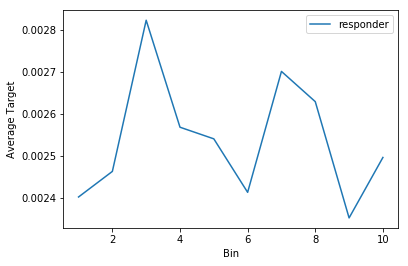

In [11]:


comb=pd.concat([x_train.loc[x_train.CAMPAIGN == 'MAR18'][['pred','CAMPAIGN']],y_train], axis=1)
plot_single_var_response(comb.loc[comb.CAMPAIGN == 'MAR18'],'pred','responder',10)

In [7]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [8]:
clf = SVC(probability=True)
#clf=MLPClassifier(early_stopping=True,hidden_layer_sizes=(20,10))
clf.fit(x_train.loc[x_train.CAMPAIGN == 'MAR18'][['pred']].values.reshape(x_train.loc[x_train.CAMPAIGN == 'MAR18'].shape[0],1),y_train.loc[x_train.CAMPAIGN == 'MAR18'].values.ravel())
#clf.fit(x_train[['pred_y']].values,y_train.values.ravel())


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

AUC is: 0.487790792693
KS: 0.0254334104684
Total Responders: 1567.0
Lift Bin 1 (Vs Mean): 0.888320161423
Lift Bin 1 (Vs Last Bin): 0.87


,Decile,Count,Responders,Actual Response Rate,Predicted Response Rate,Lift,Cume Count,Cume Responders,Cume Response Rate,Cume Lift,Min Predicted,Max Predicted
0,1,75421,174,0.002307,0.002601,0.888320,75421,174,0.002307,0.888320,0.002601,0.002602
1,2,75421,178,0.002360,0.002600,0.908741,150842,352,0.002334,0.898531,0.002600,0.002601
2,3,75421,200,0.002652,0.002599,1.021058,226263,552,0.002440,0.939373,0.002599,0.002600
3,4,75420,206,0.002731,0.002598,1.051703,301683,758,0.002513,0.967455,0.002598,0.002599
4,5,75421,196,0.002599,0.002597,1.000637,377104,954,0.002530,0.974092,0.002597,0.002598
5,6,75421,191,0.002532,0.002596,0.975110,452525,1145,0.002530,0.974261,0.002595,0.002597
6,7,75421,222,0.002943,0.002594,1.133374,527946,1367,0.002589,0.996992,0.002592,0.002595
7,8,75421,200,0.002652,0.002588,1.021058,603367,1567,0.002597,1.000000,0.002523,0.002592


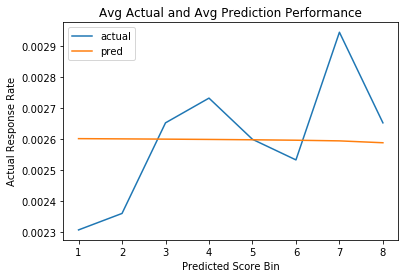

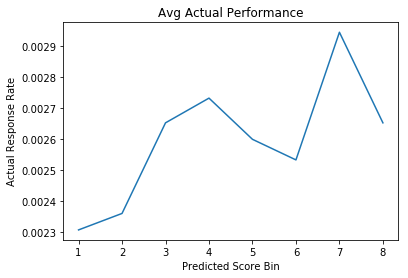

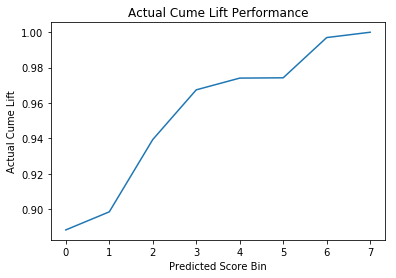

In [10]:
preds=clf.predict_proba(x_test.loc[x_test.CAMPAIGN == 'MAR18'][['pred']].values.reshape(x_test.loc[x_test.CAMPAIGN == 'MAR18'].shape[0],1))[:,1]
d=np.column_stack([y_test.loc[x_test.CAMPAIGN == 'MAR18'].values,preds]) 
eval_model_results_binary(d,8)

In [28]:
eval_model_results_binary(d,5)

ValueError: Bin edges must be unique: array([1.00000010e-07, 1.00000010e-07, 2.20694221e-07, 2.74780018e-06,
       4.93148709e-06, 1.00000000e+00]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [41]:
jan_18_topBal_y=pd.read_csv('/user-home/1014/checking_models/response_rebuild/jan_18_topBal_y.csv',header=None, names=['responder'])
jan_18_topBal_x=pd.read_csv('/user-home/1014/checking_models/response_rebuild/jan_18_topBal_x.csv')

AUC is: 0.546615735028
KS: 0.0813081914184
Total Responders: 415.0
Lift Bin 1 (Vs Mean): 1.24338019662
Lift Bin 1 (Vs Last Bin): 1.56366165087


,Decile,Count,Responders,Actual Response Rate,Predicted Response Rate,Lift,Cume Count,Cume Responders,Cume Response Rate,Cume Lift,Min Predicted,Max Predicted
0,1,61835,172,0.002782,0.000010,1.243380,61835,172,0.002782,1.243380,0.000000,0.307727
1,2,61835,133,0.002151,0.000000,0.961451,123670,305,0.002466,1.102416,0.000000,0.000000
2,3,61836,110,0.001779,0.000000,0.795172,185506,415,0.002237,1.000000,0.000000,0.000000


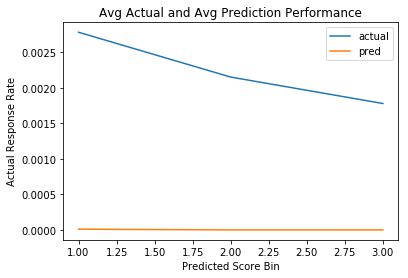

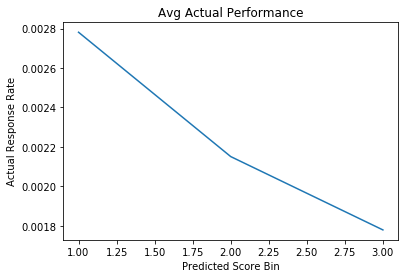

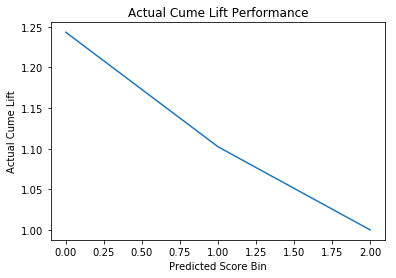

In [56]:
preds=clf.predict_proba(jan_18_topBal_x[['pred']].values)[:,1]
d=np.column_stack([jan_18_topBal_y.values,preds]) 
eval_model_results_binary(d,3)

In [28]:
mar_orig=pd.read_csv('/user-home/1014/checking_models/response_rebuild/high_bal_response/MAR_18_original.txt', na_values=['.', 'null'], dtype={'block_group':np.object, 'census_tract': np.object})


In [29]:
#random sample for a test set

msk_test = np.random.rand(len(mar_orig)) < 0.25
x_test = mar_orig[msk_test].drop('responder' ,axis=1)
y_test = mar_orig[msk_test].responder

x_test.to_csv('/user-home/1014/checking_models/response_rebuild/high_bal_response/mar_orig_testX.csv',header=True,index=False)
y_test.to_csv('/user-home/1014/checking_models/response_rebuild/high_bal_response/mar_orig_testy.csv',header=True,index=False)

joblib.dump(msk_test,'/user-home/1014/checking_models/response_rebuild/high_bal_response/msk_mar_orig_test.mask')

#non-test
remain=mar_orig[~msk_test]

del mar_orig

x_train = remain.drop('responder' ,axis=1)
y_train = remain.responder

x_train.to_csv('/user-home/1014/checking_models/response_rebuild/high_bal_response/mar_orig_trainX.csv',header=True,index=False)
y_train.to_csv('/user-home/1014/checking_models/response_rebuild/high_bal_response/mar_orig_trainy.csv',header=True,index=False)



del remain

In [3]:
x_train=pd.read_csv('/user-home/1014/checking_models/response_rebuild/high_bal_response/mar_orig_trainX.csv')
y_train=pd.read_csv('/user-home/1014/checking_models/response_rebuild/high_bal_response/mar_orig_trainy.csv')


In [19]:
x_test=pd.read_csv('/user-home/1014/checking_models/response_rebuild/high_bal_response/mar_orig_testX.csv')
y_test=pd.read_csv('/user-home/1014/checking_models/response_rebuild/high_bal_response/mar_orig_testy.csv')

fold 1 completed.
fold 2 completed.
fold 3 completed.
fold 4 completed.
fold 5 completed.
fold 6 completed.
fold 7 completed.
fold 8 completed.
fold 9 completed.
fold 10 completed.
AUC is: 0.536129803916
KS: 0.0542542104924
Total Responders: 5770.0
Lift Bin 1 (Vs Mean): 1.22183142006
Lift Bin 1 (Vs Last Bin): 1.47489539749


,Decile,Count,Responders,Actual Response Rate,Predicted Response Rate,Lift,Cume Count,Cume Responders,Cume Response Rate,Cume Lift,Min Predicted,Max Predicted
0,1,172444,705,0.004088,0.005168,1.221831,172444,705,0.004088,1.221831,0.004617,0.120494
1,2,172443,676,0.003920,0.004363,1.171578,344887,1381,0.004004,1.196705,0.004160,0.004617
2,3,172443,660,0.003827,0.004014,1.143849,517330,2041,0.003945,1.179086,0.003883,0.004160
3,4,172443,579,0.003358,0.003772,1.003467,689773,2620,0.003798,1.135182,0.003668,0.003883
4,5,172443,561,0.003253,0.003572,0.972271,862216,3181,0.003689,1.102600,0.003479,0.003668
5,6,172443,562,0.003259,0.003390,0.974005,1034659,3743,0.003618,1.081167,0.003302,0.003479
6,7,172443,511,0.002963,0.003214,0.885616,1207102,4254,0.003524,1.053231,0.003127,0.003302
7,8,172443,552,0.003201,0.003036,0.956674,1379545,4806,0.003484,1.041162,0.002943,0.003127
8,9,172443,486,0.002818,0.002836,0.842289,1551988,5292,0.003410,1.019065,0.002716,0.002943
9,10,172444,478,0.002772,0.002448,0.828419,1724432,5770,0.003346,1.000000,0.000000,0.002716


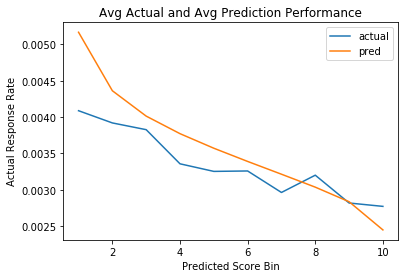

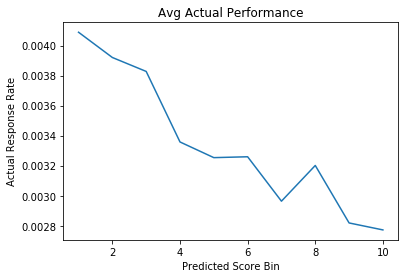

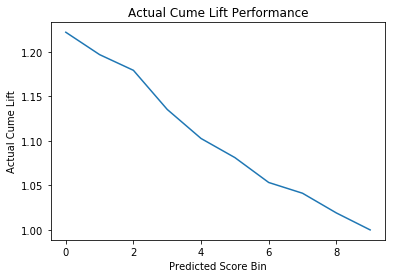

In [15]:
#hold results for training and oof
hold_results=np.zeros((x_train.shape[0],4))

#define folds
kf = KFold(n_splits=10,random_state=4528996)
counter =1

for train_index, test_index in kf.split(x_train.values):
    X_train, X_test = x_train.drop([u'unique_id', u'Person_Seq_No_1_183'],axis=1).iloc[train_index], x_train.drop([u'unique_id', u'Person_Seq_No_1_183'],axis=1).iloc[test_index]
    Y_train, Y_test = y_train.values[train_index], y_train.values[test_index]
    
    #fit
    #clf_cat=CatBoostClassifier(iterations=10, depth=2, learning_rate=0.03, loss_function='Logloss',nan_mode='Min',random_seed=42, thread_count=8)
    #clf_cat.fit(X_train.values,Y_train.ravel())
    
    x1= dmatrix("cr(x, df=3) - 1", {"x":X_train.new_hhs_24_NORM_CT.fillna(0).values})
    x2= dmatrix("cr(x, df=3) - 1", {"x":X_train.income.fillna(0).values})
    x3= dmatrix("cr(x, df=3) - 1", {"x":X_train.Pen_ALL.fillna(0).values})
    x4= dmatrix("cr(x, df=3) - 1", {"x":X_train.SHARE_CheckBAL.fillna(0).values})
    x5= dmatrix("cr(x, df=3) - 1", {"x":X_train.Target_PreMover_20_Model_879.fillna(0).values})
    x6= dmatrix("cr(x, df=3) - 1", {"x":X_train.new_hhs_24_NORM_CT_CHK.fillna(0).values})
    x7= dmatrix("cr(x, df=3) - 1", {"x":X_train.new_hhs_24.fillna(0).values})
    x8= dmatrix("cr(x, df=3) - 1", {"x":X_train.Pen_Check.fillna(0).values})
    x9= dmatrix("cr(x, df=3) - 1", {"x":X_train.pred.fillna(0).values})
    x10= dmatrix("cr(x, df=3) - 1", {"x":X_train.Home_value.fillna(0).values})
    x11= dmatrix("cr(x, df=3) - 1", {"x":X_train.Mortgage_Liability.fillna(0).values})


    DMA_train=X_train[['DMA_1',
    'DMA_2',
    'DMA_3',
    'DMA_4',
    'DMA_5',
    'DMA_6',
    'DMA_7',
    'DMA_8',
    'DMA_9',
    'DMA_10',
    'DMA_11',
    'DMA_12',
    'DMA_13',
    'DMA_14',
    'DMA_15',
    'DMA_16',
    'DMA_17',
    'DMA_18',
    'DMA_19',
    'DMA_20',
    'DMA_21',
    'DMA_22']]
    
    DMA_test=X_test[['DMA_1',
    'DMA_2',
    'DMA_3',
    'DMA_4',
    'DMA_5',
    'DMA_6',
    'DMA_7',
    'DMA_8',
    'DMA_9',
    'DMA_10',
    'DMA_11',
    'DMA_12',
    'DMA_13',
    'DMA_14',
    'DMA_15',
    'DMA_16',
    'DMA_17',
    'DMA_18',
    'DMA_19',
    'DMA_20',
    'DMA_21',
    'DMA_22']]
    
    
    Z=np.column_stack([DMA_train.values,    
    x1,
    x2,
    x3,
    x4,
    x5,
    x6,
    x7,
    x8,
    x9,x10,x11
                      ])
                   
    xx1=build_design_matrices([x1.design_info], {"x":X_test.new_hhs_24_NORM_CT.fillna(0).values })
    xx2=build_design_matrices([x2.design_info], {"x":X_test.income.fillna(0).values })
    xx3=build_design_matrices([x3.design_info], {"x":X_test.Pen_ALL.fillna(0).values })
    xx4=build_design_matrices([x4.design_info], {"x":X_test.SHARE_CheckBAL.fillna(0).values })
    xx5=build_design_matrices([x5.design_info], {"x":X_test.Target_PreMover_20_Model_879.fillna(0).values })
    xx6=build_design_matrices([x6.design_info], {"x":X_test.new_hhs_24_NORM_CT_CHK.fillna(0).values })
    xx7=build_design_matrices([x7.design_info], {"x":X_test.new_hhs_24.fillna(0).values })
    xx8=build_design_matrices([x8.design_info], {"x":X_test.Pen_Check.fillna(0).values })
    xx9=build_design_matrices([x9.design_info], {"x":X_test.pred.fillna(0).values })
    xx10=build_design_matrices([x10.design_info], {"x":X_test.Home_value.fillna(0).values })
    xx11=build_design_matrices([x11.design_info], {"x":X_test.Mortgage_Liability.fillna(0).values })

        
    Z2=np.column_stack(
    [
DMA_test.values,
np.array(xx1[0]),
np.array(xx2[0]),
np.array(xx3[0]),
np.array(xx4[0]),
np.array(xx5[0]),
np.array(xx6[0]),
np.array(xx7[0]),
np.array(xx8[0])
        ,np.array(xx9[0]),
        np.array(xx10[0])
        ,np.array(xx11[0])
    ])
    
    
    
    #ridge logistic
    LR=LogisticRegression(C=100000)#penalty='l1',solver='liblinear')
    LR.fit(Z, Y_train.ravel())

    #xgboost linear
    #dtrain=xgb.DMatrix(Z, Y_train.ravel())
    #dtest=xgb.DMatrix(Z2, Y_test.ravel())
    
    #params={'booster':'gblinear', 'objective': 'binary:logistic', 'seed':12564, 'learning_rate':0.05}
    #xgbMod=xgb.train(params, dtrain,num_boost_round=10)
    
    
    
    #score
    #LR
    pred_train=LR.predict_proba(Z)[:,1]
    pred_test=LR.predict_proba(Z2)[:,1]
    
    #xgb
    #pred_train_xg=xgbMod.predict(dtrain)
    #pred_test_xg=xgbMod.predict(dtest)    
    
    #pred_train=(pred_train+pred_train_xg)/2
    #pred_test=(pred_test+pred_test_xg)/2
    
    hold_results[train_index,0]=Y_train.ravel() #traing actual
    hold_results[train_index,1]=pred_train #training pred
    hold_results[test_index,2]=Y_test.ravel() #test actual
    hold_results[test_index,3]=pred_test #test pred
    
    print('fold '+ str(counter)+' completed.')
    
    counter= counter +1
    
d=np.column_stack([hold_results[:,2],hold_results[:,3]]) #out of fold
eval_model_results_binary(d,10)
    

In [16]:
x1= dmatrix("cr(x, df=3) - 1", {"x":x_train.new_hhs_24_NORM_CT.fillna(0).values})
x2= dmatrix("cr(x, df=3) - 1", {"x":x_train.income.fillna(0).values})
x3= dmatrix("cr(x, df=3) - 1", {"x":x_train.Pen_ALL.fillna(0).values})
x4= dmatrix("cr(x, df=3) - 1", {"x":x_train.SHARE_CheckBAL.fillna(0).values})
x5= dmatrix("cr(x, df=3) - 1", {"x":x_train.Target_PreMover_20_Model_879.fillna(0).values})
x6= dmatrix("cr(x, df=3) - 1", {"x":x_train.new_hhs_24_NORM_CT_CHK.fillna(0).values})
x7= dmatrix("cr(x, df=3) - 1", {"x":x_train.new_hhs_24.fillna(0).values})
x8= dmatrix("cr(x, df=3) - 1", {"x":x_train.Pen_Check.fillna(0).values})
x9= dmatrix("cr(x, df=3) - 1", {"x":x_train.pred.fillna(0).values})
x10= dmatrix("cr(x, df=3) - 1", {"x":x_train.Home_value.fillna(0).values})
x11= dmatrix("cr(x, df=3) - 1", {"x":x_train.Mortgage_Liability.fillna(0).values})

DMA_train=x_train[['DMA_1',
    'DMA_2',
    'DMA_3',
    'DMA_4',
    'DMA_5',
    'DMA_6',
    'DMA_7',
    'DMA_8',
    'DMA_9',
    'DMA_10',
    'DMA_11',
    'DMA_12',
    'DMA_13',
    'DMA_14',
    'DMA_15',
    'DMA_16',
    'DMA_17',
    'DMA_18',
    'DMA_19',
    'DMA_20',
    'DMA_21',
    'DMA_22']]
    
    
Z=np.column_stack([DMA_train.values,    
    x1,
    x2,
    x3,
    x4,
    x5,
    x6,
    x7,
    x8
    ,x9,x10,x11
                  ])

LR=LogisticRegression(C=100000)
LR.fit(Z, y_train.values.ravel())

joblib.dump(LR,'/user-home/1014/checking_models/response_rebuild/high_bal_response/mar_orig_lrmod.pkl')


['/user-home/1014/checking_models/response_rebuild/high_bal_response/mar_orig_lrmod.pkl']

In [17]:
LR=joblib.load('/user-home/1014/checking_models/response_rebuild/high_bal_response/mar_orig_lrmod.pkl')

AUC is: 0.561013715675
KS: 0.0998043949138
Total Responders: 1902.0
Lift Bin 1 (Vs Mean): 1.31703012386
Lift Bin 1 (Vs Last Bin): 1.7703180212


,Decile,Count,Responders,Actual Response Rate,Predicted Response Rate,Lift,Cume Count,Cume Responders,Cume Response Rate,Cume Lift,Min Predicted,Max Predicted
0,1,115114,501,0.004352,0.004364,1.317030,115114,501,0.004352,1.317030,0.003812,0.550054
1,2,115113,449,0.003901,0.003588,1.180343,230227,950,0.004126,1.248687,0.003403,0.003812
2,3,115114,340,0.002954,0.003252,0.893793,345341,1290,0.003735,1.130388,0.003109,0.003403
3,4,115113,329,0.002858,0.002969,0.864884,460454,1619,0.003516,1.064012,0.002821,0.003109
4,5,115114,283,0.002458,0.002561,0.743951,575568,1902,0.003305,1.000000,0.000000,0.002821


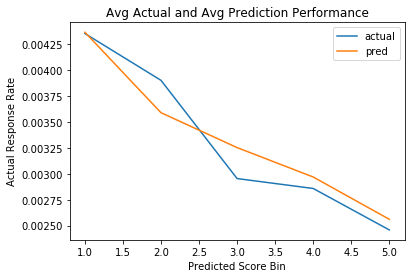

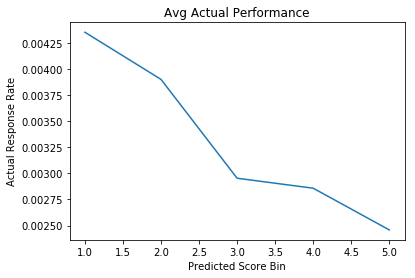

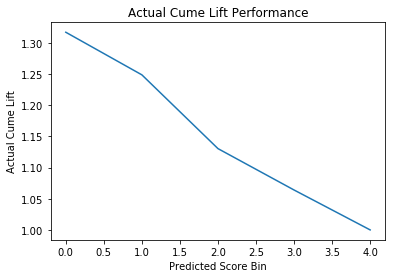

In [20]:
xx1=build_design_matrices([x1.design_info], {"x":x_test.new_hhs_24_NORM_CT.fillna(0).values })
xx2=build_design_matrices([x2.design_info], {"x":x_test.income.fillna(0).values })
xx3=build_design_matrices([x3.design_info], {"x":x_test.Pen_ALL.fillna(0).values })
xx4=build_design_matrices([x4.design_info], {"x":x_test.SHARE_CheckBAL.fillna(0).values })
xx5=build_design_matrices([x5.design_info], {"x":x_test.Target_PreMover_20_Model_879.fillna(0).values })
xx6=build_design_matrices([x6.design_info], {"x":x_test.new_hhs_24_NORM_CT_CHK.fillna(0).values })
xx7=build_design_matrices([x7.design_info], {"x":x_test.new_hhs_24.fillna(0).values })
xx8=build_design_matrices([x8.design_info], {"x":x_test.Pen_Check.fillna(0).values })
xx9=build_design_matrices([x9.design_info], {"x":x_test.pred.fillna(0).values })
xx10=build_design_matrices([x10.design_info], {"x":x_test.Home_value.fillna(0).values })
xx11=build_design_matrices([x11.design_info], {"x":x_test.Mortgage_Liability.fillna(0).values })
            
DMA_test=x_test[['DMA_1',
    'DMA_2',
    'DMA_3',
    'DMA_4',
    'DMA_5',
    'DMA_6',
    'DMA_7',
    'DMA_8',
    'DMA_9',
    'DMA_10',
    'DMA_11',
    'DMA_12',
    'DMA_13',
    'DMA_14',
    'DMA_15',
    'DMA_16',
    'DMA_17',
    'DMA_18',
    'DMA_19',
    'DMA_20',
    'DMA_21',
    'DMA_22']]   
    

Z2=np.column_stack(
    [
DMA_test.values,
np.array(xx1[0]),
np.array(xx2[0]),
np.array(xx3[0]),
np.array(xx4[0]),
np.array(xx5[0]),
np.array(xx6[0]),
np.array(xx7[0]),
np.array(xx8[0]),
np.array(xx9[0]),
        np.array(xx10[0]),
np.array(xx11[0])
    ])

pred=LR.predict_proba(Z2)[:,1]
d=np.column_stack([y_test.values,pred]) #out of fold
eval_model_results_binary(d,5)

AUC is: 0.561013715675
KS: 0.0998043949138
Total Responders: 1902.0
Lift Bin 1 (Vs Mean): 1.40903821635
Lift Bin 1 (Vs Last Bin): 1.98518518519


,Decile,Count,Responders,Actual Response Rate,Predicted Response Rate,Lift,Cume Count,Cume Responders,Cume Response Rate,Cume Lift,Min Predicted,Max Predicted
0,1,57557,268,0.004656,0.004746,1.409038,57557,268,0.004656,1.409038,0.004199,0.550054
1,2,57557,233,0.004048,0.003983,1.225022,115114,501,0.004352,1.317030,0.003812,0.004199
2,3,57557,230,0.003996,0.003689,1.209249,172671,731,0.004233,1.281103,0.003580,0.003812
3,4,57556,219,0.003805,0.003488,1.151436,230227,950,0.004126,1.248687,0.003403,0.003580
4,5,57557,176,0.003058,0.003325,0.925339,287784,1126,0.003913,1.184017,0.003250,0.003403
5,6,57557,164,0.002849,0.003179,0.862247,345341,1290,0.003735,1.130388,0.003109,0.003250
6,7,57556,163,0.002832,0.003040,0.857005,402897,1453,0.003606,1.091334,0.002970,0.003109
7,8,57557,166,0.002884,0.002898,0.872762,460454,1619,0.003516,1.064012,0.002821,0.002970
8,9,57557,148,0.002571,0.002728,0.778126,518011,1767,0.003411,1.032247,0.002621,0.002821
9,10,57557,135,0.002346,0.002394,0.709777,575568,1902,0.003305,1.000000,0.000000,0.002621


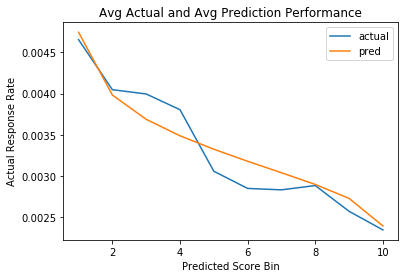

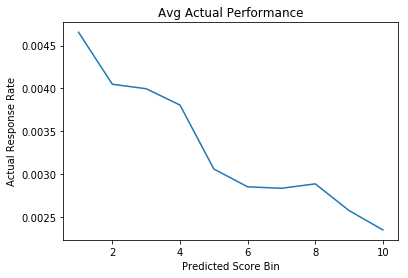

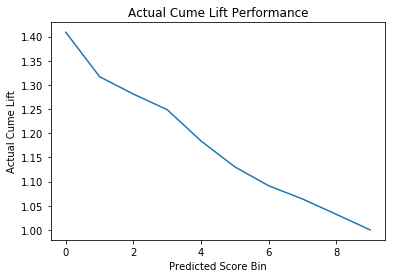

In [21]:
pred=LR.predict_proba(Z2)[:,1]
d=np.column_stack([y_test.values,pred]) #out of fold
eval_model_results_binary(d,10)

Index([u'new_hhs_24_NORM_CT', u'Home_value', u'Mortgage_Liability', u'income',
       u'closest_dist', u'Pen_ALL', u'SHARE_CheckBAL',
       u'Target_PreMover_20_Model_879', u'DEP_BAL_53_TO_NIELSEN',
       u'new_hhs_24_NORM_CT_CHK', u'GPR_IND', u'IXI_MM_PROP',
       u'Advantage_Length_of_Residen_823', u'DMA_1', u'DMA_2', u'DMA_3',
       u'DMA_4', u'DMA_5', u'DMA_6', u'DMA_7', u'DMA_8', u'DMA_9', u'DMA_10',
       u'DMA_11', u'DMA_12', u'DMA_13', u'DMA_14', u'DMA_15', u'DMA_16',
       u'DMA_17', u'DMA_18', u'DMA_19', u'DMA_20', u'DMA_21', u'DMA_22',
       u'new_hhs_24', u'Pen_Check', u'unique_id', u'Person_Seq_No_1_183',
       u'pred', u'responder', u'decile'],
      dtype='object')

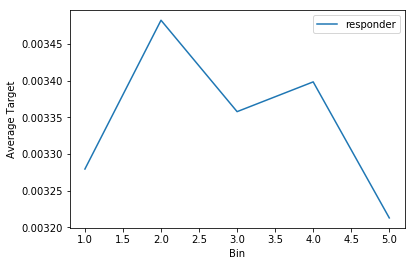

In [50]:
#comb=pd.concat([x_train,y_train],axis=1)

plot_single_var_response(comb,'pred','responder',5)
comb.columns
#comb.groupby(['DMA_12'])['responder'].sum()

In [ ]:
new_hhs_24_NORM_CT
income
Pen_ALL
SHARE_CheckBAL
Target_PreMover_20_Model_879
new_hhs_24_NORM_CT_CHK
new_hhs_24
Pen_Check

AUC is: 0.541149836935
KS: 0.0595022751508
Total Responders: 1902.0
Lift Bin 1 (Vs Mean): 1.17770358381
Lift Bin 1 (Vs Last Bin): 1.73643410853


,Decile,Count,Responders,Actual Response Rate,Predicted Response Rate,Lift,Cume Count,Cume Responders,Cume Response Rate,Cume Lift,Min Predicted,Max Predicted
0,1,57557,224,0.003892,0.003615,1.177704,57557,224,0.003892,1.177704,0.003527,0.004650
1,2,57557,220,0.003822,0.003485,1.156673,115114,444,0.003857,1.167188,0.003448,0.003527
2,3,57557,196,0.003405,0.003420,1.030491,172671,640,0.003706,1.121622,0.003395,0.003448
3,4,57556,233,0.004048,0.003374,1.225043,230227,873,0.003792,1.147477,0.003356,0.003395
4,5,57557,185,0.003214,0.003339,0.972657,287784,1058,0.003676,1.112513,0.003324,0.003356
5,6,57557,196,0.003405,0.003310,1.030491,345341,1254,0.003631,1.098843,0.003296,0.003324
6,7,57556,189,0.003284,0.003282,0.993705,402897,1443,0.003582,1.083823,0.003268,0.003296
7,8,57557,164,0.002849,0.003254,0.862247,460454,1607,0.003490,1.056126,0.003238,0.003268
8,9,57557,166,0.002884,0.003222,0.872762,518011,1773,0.003423,1.035752,0.003205,0.003238
9,10,57557,129,0.002241,0.003176,0.678231,575568,1902,0.003305,1.000000,0.002443,0.003205


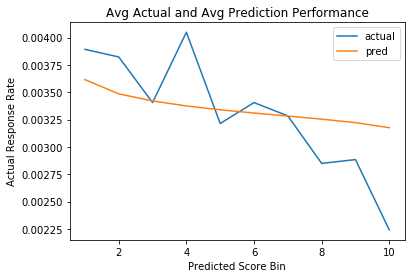

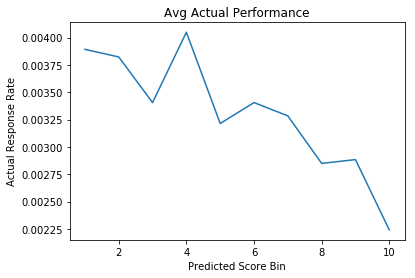

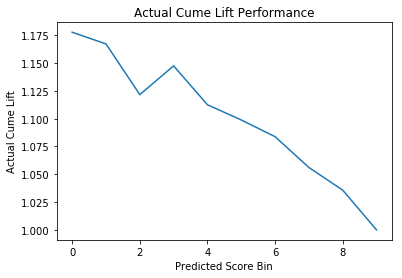

In [37]:
pred=LR.predict_proba(Z2)[:,1]
d=np.column_stack([y_test.values,pred]) #out of fold
eval_model_results_binary(d,)

fold 1 completed.
fold 2 completed.
AUC is: 0.508023441523
KS: 0.0184322106584
Total Responders: 5770.0
Lift Bin 1 (Vs Mean): 1.15424074576
Lift Bin 1 (Vs Last Bin): 1.23562152134


,Decile,Count,Responders,Actual Response Rate,Predicted Response Rate,Lift,Cume Count,Cume Responders,Cume Response Rate,Cume Lift,Min Predicted,Max Predicted
0,1,172444,666,0.003862,0.003389,1.154241,172444,666,0.003862,1.154241,0.003389,0.003389
1,2,172443,594,0.003445,0.003389,1.029464,344887,1260,0.003653,1.091853,0.003389,0.003389
2,3,172443,552,0.003201,0.003389,0.956674,517330,1812,0.003503,1.046793,0.003389,0.003389
3,4,172443,573,0.003323,0.003389,0.993069,689773,2385,0.003458,1.033362,0.003389,0.003389
4,5,172443,463,0.002685,0.003389,0.802427,862216,2848,0.003303,0.987175,0.003389,0.003389
5,6,172443,596,0.003456,0.003303,1.032930,1034659,3444,0.003329,0.994801,0.003303,0.003303
6,7,172443,621,0.003601,0.003303,1.076258,1207102,4065,0.003368,1.006438,0.003303,0.003303
7,8,172443,604,0.003503,0.003303,1.046795,1379545,4669,0.003384,1.011482,0.003303,0.003303
8,9,172443,562,0.003259,0.003303,0.974005,1551988,5231,0.003371,1.007318,0.003303,0.003303
9,10,172444,539,0.003126,0.003303,0.934138,1724432,5770,0.003346,1.000000,0.003303,0.003303


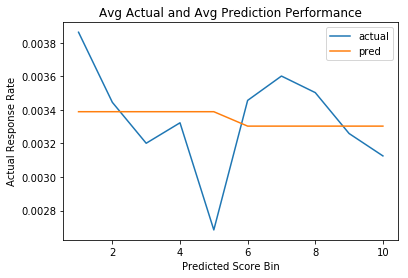

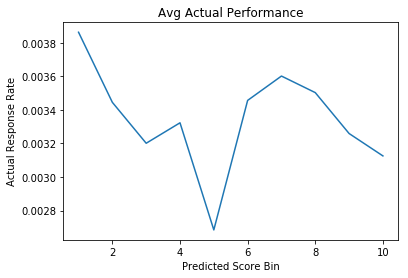

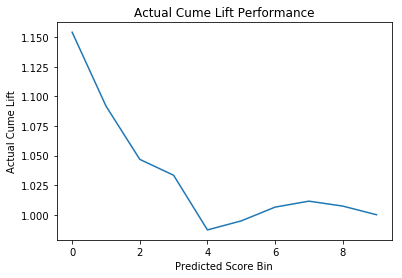

In [5]:
from sklearn.linear_model import SGDClassifier, LogisticRegression

#hold results for training and oof
hold_results=np.zeros((x_train.shape[0],4))

RANDOM_SEED=45763
np.random.seed(RANDOM_SEED )

#define folds
kf = KFold(n_splits=2,random_state=4528996)
counter =1

from sklearn.preprocessing import StandardScaler

for train_index, test_index in kf.split(x_train.values):
    X_train, X_test = x_train.drop([u'unique_id', u'Person_Seq_No_1_183'],axis=1).iloc[train_index], x_train.drop([u'unique_id', u'Person_Seq_No_1_183'],axis=1).iloc[test_index]
    Y_train, Y_test = y_train.values[train_index], y_train.values[test_index]
    
    X_train=X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_test=X_test.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    
    
    #cubic splines
    
    x1= dmatrix("cr(x, df=3) - 1", {"x":X_train.new_hhs_24_NORM_CT.fillna(0).values})
    x2= dmatrix("cr(x, df=3) - 1", {"x":X_train.income.fillna(0).values})
    x3= dmatrix("cr(x, df=3) - 1", {"x":X_train.Pen_ALL.fillna(0).values})
    x4= dmatrix("cr(x, df=3) - 1", {"x":X_train.SHARE_CheckBAL.fillna(0).values})
    x5= dmatrix("cr(x, df=3) - 1", {"x":X_train.Target_PreMover_20_Model_879.fillna(0).values})
    x6= dmatrix("cr(x, df=3) - 1", {"x":X_train.new_hhs_24_NORM_CT_CHK.fillna(0).values})
    x7= dmatrix("cr(x, df=3) - 1", {"x":X_train.new_hhs_24.fillna(0).values})
    x8= dmatrix("cr(x, df=3) - 1", {"x":X_train.Pen_Check.fillna(0).values})
    x9= dmatrix("cr(x, df=3) - 1", {"x":X_train.pred.fillna(0).values})
    x10= dmatrix("cr(x, df=3) - 1", {"x":X_train.Home_value.fillna(0).values})
    x11= dmatrix("cr(x, df=3) - 1", {"x":X_train.Mortgage_Liability.fillna(0).values})


    DMA_train=X_train[['DMA_1',
    'DMA_2',
    'DMA_3',
    'DMA_4',
    'DMA_5',
    'DMA_6',
    'DMA_7',
    'DMA_8',
    'DMA_9',
    'DMA_10',
    'DMA_11',
    'DMA_12',
    'DMA_13',
    'DMA_14',
    'DMA_15',
    'DMA_16',
    'DMA_17',
    'DMA_18',
    'DMA_19',
    'DMA_20',
    'DMA_21',
    'DMA_22']]
    
    DMA_test=X_test[['DMA_1',
    'DMA_2',
    'DMA_3',
    'DMA_4',
    'DMA_5',
    'DMA_6',
    'DMA_7',
    'DMA_8',
    'DMA_9',
    'DMA_10',
    'DMA_11',
    'DMA_12',
    'DMA_13',
    'DMA_14',
    'DMA_15',
    'DMA_16',
    'DMA_17',
    'DMA_18',
    'DMA_19',
    'DMA_20',
    'DMA_21',
    'DMA_22']]
    
    
    Z=np.column_stack([DMA_train.values,    
    x1,
    x2,
    x3,
    x4,
    x5,
    x6,
    x7,
    x8,
    x9,x10,x11
                      ])
                   
    xx1=build_design_matrices([x1.design_info], {"x":X_test.new_hhs_24_NORM_CT.fillna(0).values })
    xx2=build_design_matrices([x2.design_info], {"x":X_test.income.fillna(0).values })
    xx3=build_design_matrices([x3.design_info], {"x":X_test.Pen_ALL.fillna(0).values })
    xx4=build_design_matrices([x4.design_info], {"x":X_test.SHARE_CheckBAL.fillna(0).values })
    xx5=build_design_matrices([x5.design_info], {"x":X_test.Target_PreMover_20_Model_879.fillna(0).values })
    xx6=build_design_matrices([x6.design_info], {"x":X_test.new_hhs_24_NORM_CT_CHK.fillna(0).values })
    xx7=build_design_matrices([x7.design_info], {"x":X_test.new_hhs_24.fillna(0).values })
    xx8=build_design_matrices([x8.design_info], {"x":X_test.Pen_Check.fillna(0).values })
    xx9=build_design_matrices([x9.design_info], {"x":X_test.pred.fillna(0).values })
    xx10=build_design_matrices([x10.design_info], {"x":X_test.Home_value.fillna(0).values })
    xx11=build_design_matrices([x11.design_info], {"x":X_test.Mortgage_Liability.fillna(0).values })

        
    Z2=np.column_stack(
    [
DMA_test.values,
np.array(xx1[0]),
np.array(xx2[0]),
np.array(xx3[0]),
np.array(xx4[0]),
np.array(xx5[0]),
np.array(xx6[0]),
np.array(xx7[0]),
np.array(xx8[0])
,np.array(xx9[0]),
np.array(xx10[0])
,np.array(xx11[0])
    ])
    
    
    #standardize Z
    #stsc=StandardScaler()
    #stsc.fit(Z)
    #Z=stsc.transform(Z)
    #Z2=stsc.transform(Z2)
    
    
    #models
    clf1=xgb.XGBClassifier(booster='gblinear', objective= 'binary:logistic', seed=12564, learning_rate=0.05, reg_alpha=0.5, nthreads=-1)
    clf2= LogisticRegressionCV()
    
    lr= LogisticRegressionCV()
    #now can fit models
    
    

    sclf = StackingCVClassifier(classifiers=[clf1, clf2],shuffle=True,stratify=True,store_train_meta_features=True,use_probas=True,meta_classifier=lr, cv=3)
    
    
    #score
    
    sclf.fit(Z,Y_train.ravel())
    pred_train =sclf.predict_proba(Z)[:,1]
    pred_test =sclf.predict_proba(Z2)[:,1]
    
    
        
    hold_results[train_index,0]=Y_train.ravel() #traing actual
    hold_results[train_index,1]=pred_train #training pred
    hold_results[test_index,2]=Y_test.ravel() #test actual
    hold_results[test_index,3]=pred_test #test pred
    
    print('fold '+ str(counter)+' completed.')
    
    counter= counter +1
    
d=np.column_stack([hold_results[:,2],hold_results[:,3]]) #out of fold
eval_model_results_binary(d,10)
    

In [114]:
d=np.column_stack([sclf.train_meta_features_[:,7],Y_train]) #out of fold
eval_model_results_binary(d,10)

ValueError: Bin edges must be unique: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]).
You can drop duplicate edges by setting the 'duplicates' kwarg

fold 1 completed.
fold 2 completed.
AUC is: 0.506018676065
KS: 0.0248663337392
Total Responders: 5770.0
Lift Bin 1 (Vs Mean): 1.0797176946
Lift Bin 1 (Vs Last Bin): 1.09106830123


,Decile,Count,Responders,Actual Response Rate,Predicted Response Rate,Lift,Cume Count,Cume Responders,Cume Response Rate,Cume Lift,Min Predicted,Max Predicted
0,1,172444,623,0.003613,0.204445,1.079718,172444,623,0.003613,1.079718,0.203777,3.412639
1,2,172443,627,0.003636,0.203575,1.086656,344887,1250,0.003624,1.083187,0.203412,0.203777
2,3,172443,624,0.003619,0.203280,1.081457,517330,1874,0.003622,1.082610,0.203152,0.203412
3,4,172443,524,0.003039,0.203012,0.908147,689773,2398,0.003477,1.038994,0.202859,0.203152
4,5,172443,538,0.003120,0.202609,0.932410,862216,2936,0.003405,1.017678,0.202189,0.202859
5,6,172443,519,0.003010,0.200461,0.899481,1034659,3455,0.003339,0.997978,0.198896,0.202189
6,7,172443,566,0.003282,0.197565,0.980937,1207102,4021,0.003331,0.995544,0.195319,0.198896
7,8,172443,549,0.003184,0.187510,0.951474,1379545,4570,0.003313,0.990035,0.178137,0.195319
8,9,172443,629,0.003648,0.140497,1.090123,1551988,5199,0.003350,1.001156,0.062898,0.178137
9,10,172444,571,0.003311,0.015665,0.989597,1724432,5770,0.003346,1.000000,0.000755,0.062897


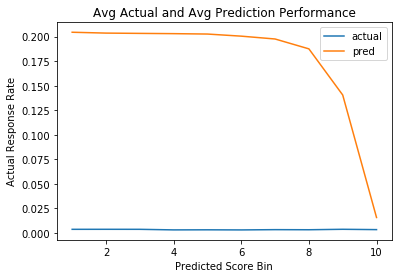

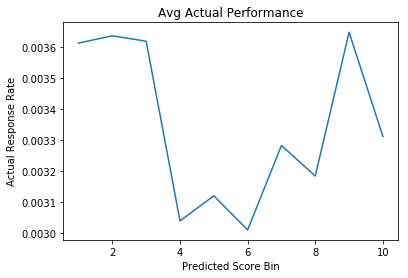

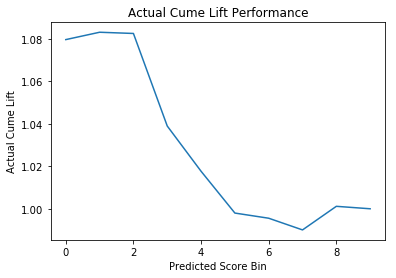

In [5]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC 
from sklearn.naive_bayes import GaussianNB

#hold results for training and oof
hold_results=np.zeros((x_train.shape[0],9))

#define folds
kf = KFold(n_splits=2,random_state=4528996)
counter =1

from sklearn.preprocessing import StandardScaler

for train_index, test_index in kf.split(x_train.values):
    X_train, X_test = x_train.drop([u'unique_id', u'Person_Seq_No_1_183'],axis=1).iloc[train_index], x_train.drop([u'unique_id', u'Person_Seq_No_1_183'],axis=1).iloc[test_index]
    Y_train, Y_test = y_train.values[train_index], y_train.values[test_index]
    
    X_train=X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_test=X_test.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    
    
    #cubic splines
    
    x1= dmatrix("cr(x, df=3) - 1", {"x":X_train.new_hhs_24_NORM_CT.fillna(0).values})
    x2= dmatrix("cr(x, df=3) - 1", {"x":X_train.income.fillna(0).values})
    x3= dmatrix("cr(x, df=3) - 1", {"x":X_train.Pen_ALL.fillna(0).values})
    x4= dmatrix("cr(x, df=3) - 1", {"x":X_train.SHARE_CheckBAL.fillna(0).values})
    x5= dmatrix("cr(x, df=3) - 1", {"x":X_train.Target_PreMover_20_Model_879.fillna(0).values})
    x6= dmatrix("cr(x, df=3) - 1", {"x":X_train.new_hhs_24_NORM_CT_CHK.fillna(0).values})
    x7= dmatrix("cr(x, df=3) - 1", {"x":X_train.new_hhs_24.fillna(0).values})
    x8= dmatrix("cr(x, df=3) - 1", {"x":X_train.Pen_Check.fillna(0).values})
    x9= dmatrix("cr(x, df=3) - 1", {"x":X_train.pred.fillna(0).values})
    x10= dmatrix("cr(x, df=3) - 1", {"x":X_train.Home_value.fillna(0).values})
    x11= dmatrix("cr(x, df=3) - 1", {"x":X_train.Mortgage_Liability.fillna(0).values})


    DMA_train=X_train[['DMA_1',
    'DMA_2',
    'DMA_3',
    'DMA_4',
    'DMA_5',
    'DMA_6',
    'DMA_7',
    'DMA_8',
    'DMA_9',
    'DMA_10',
    'DMA_11',
    'DMA_12',
    'DMA_13',
    'DMA_14',
    'DMA_15',
    'DMA_16',
    'DMA_17',
    'DMA_18',
    'DMA_19',
    'DMA_20',
    'DMA_21',
    'DMA_22']]
    
    DMA_test=X_test[['DMA_1',
    'DMA_2',
    'DMA_3',
    'DMA_4',
    'DMA_5',
    'DMA_6',
    'DMA_7',
    'DMA_8',
    'DMA_9',
    'DMA_10',
    'DMA_11',
    'DMA_12',
    'DMA_13',
    'DMA_14',
    'DMA_15',
    'DMA_16',
    'DMA_17',
    'DMA_18',
    'DMA_19',
    'DMA_20',
    'DMA_21',
    'DMA_22']]
    
    
    Z=np.column_stack([DMA_train.values,    
    x1,
    x2,
    x3,
    x4,
    x5,
    x6,
    x7,
    x8,
    x9,x10,x11
                      ])
                   
    xx1=build_design_matrices([x1.design_info], {"x":X_test.new_hhs_24_NORM_CT.fillna(0).values })
    xx2=build_design_matrices([x2.design_info], {"x":X_test.income.fillna(0).values })
    xx3=build_design_matrices([x3.design_info], {"x":X_test.Pen_ALL.fillna(0).values })
    xx4=build_design_matrices([x4.design_info], {"x":X_test.SHARE_CheckBAL.fillna(0).values })
    xx5=build_design_matrices([x5.design_info], {"x":X_test.Target_PreMover_20_Model_879.fillna(0).values })
    xx6=build_design_matrices([x6.design_info], {"x":X_test.new_hhs_24_NORM_CT_CHK.fillna(0).values })
    xx7=build_design_matrices([x7.design_info], {"x":X_test.new_hhs_24.fillna(0).values })
    xx8=build_design_matrices([x8.design_info], {"x":X_test.Pen_Check.fillna(0).values })
    xx9=build_design_matrices([x9.design_info], {"x":X_test.pred.fillna(0).values })
    xx10=build_design_matrices([x10.design_info], {"x":X_test.Home_value.fillna(0).values })
    xx11=build_design_matrices([x11.design_info], {"x":X_test.Mortgage_Liability.fillna(0).values })

        
    Z2=np.column_stack(
    [
DMA_test.values,
np.array(xx1[0]),
np.array(xx2[0]),
np.array(xx3[0]),
np.array(xx4[0]),
np.array(xx5[0]),
np.array(xx6[0]),
np.array(xx7[0]),
np.array(xx8[0])
,np.array(xx9[0]),
np.array(xx10[0])
,np.array(xx11[0])
    ])
    
    
    #standardize Z
    #stsc=StandardScaler()
    #stsc.fit(Z)
    #Z=stsc.transform(Z)
    #Z2=stsc.transform(Z2)
    
    
    #models
    clf1=xgb.XGBClassifier(booster='gblinear', objective= 'binary:logistic', seed=12564, learning_rate=0.05, reg_alpha=0.5, nthreads=-1)
    clf2=xgb.XGBClassifier(booster='gblinear', objective= 'count:poisson', seed=12564, learning_rate=0.01, reg_alpha=0.5, reg_lambda=0.01,nthreads=-1)
    clf3= LogisticRegressionCV()
   # clf4 =LogisticRegressionCV(penalty='l1',solver='saga',max_iter=250)
    #clf4=SVC(kernel='linear' ,probability=True)
    clf4=GaussianNB()
    clf5= LogisticRegression(C=10000)
    #now can fit models
    
    

    #sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3,clf4],shuffle=True,stratify=True,store_train_meta_features=True,use_probas=True,meta_classifier=lr, cv=3)

    
    #LR=LogisticRegressionCV()#penalty='l1',solver='liblinear')
    #LR.fit(Z, Y_train.ravel())
    
    #LR2=LogisticRegressionCV(penalty='l1',solver='saga')
    #LR2.fit(Z, Y_train.ravel())
    
    #xgboost linear
    #dtrain=xgb.DMatrix(Z, Y_train.ravel())
    #dtest=xgb.DMatrix(Z2, Y_test.ravel())
    
    #params={'booster':'gblinear', 'objective': 'binary:logistic', 'seed':12564, 'learning_rate':0.05, 'alpha':0.5, 'nthreads':-1 }
    #xgbMod1=xgb.train(params, dtrain,num_boost_round=150)
    #params={'booster':'gblinear', 'objective': "count:poisson", 'seed':12564, 'learning_rate':0.01, 'alpha':0.5,'lambda':0.01, 'nthreads':-1 }
    #xgbMod2=xgb.train(params, dtrain,num_boost_round=250)
    
    
    clf1.fit(Z, Y_train.ravel())
    pred_train1 =clf1.predict_proba(Z)[:,1]
    pred_test1 =clf1.predict_proba(Z2)[:,1]
    
    clf2.fit(Z, Y_train.ravel())
    pred_train2 =clf2.predict_proba(Z)[:,1]
    pred_test2 =clf2.predict_proba(Z2)[:,1]
    
    clf3.fit(Z, Y_train.ravel())
    pred_train3 =clf3.predict_proba(Z)[:,1]
    pred_test3 =clf3.predict_proba(Z2)[:,1]
    
    clf4.fit(Z, Y_train.ravel())
    pred_train4 =clf4.predict_proba(Z)[:,1]
    pred_test4 =clf4.predict_proba(Z2)[:,1]
    
    clf5.fit(Z, Y_train.ravel())
    pred_train5 =clf5.predict_proba(Z)[:,1]
    pred_test5 =clf5.predict_proba(Z2)[:,1]
    
    
    #score
    
    #sclf.fit(Z,Y_train.ravel())
    #pred_train =sclf.predict_proba(Z)[:,1]
    #pred_test =sclf.predict_proba(Z2)[:,1]
    
    
    
    
    #xgb
    #pred_train1=xgbMod1.predict(dtrain)
    #pred_test1=xgbMod1.predict(dtest)  
    
    #pred_train2=xgbMod2.predict(dtrain)
    #pred_test2=xgbMod2.predict(dtest)  
    
    
    #LR
    #pred_train3=LR.predict_proba(Z)[:,1]
    #pred_test3=LR.predict_proba(Z2)[:,1]

    #pred_train4=LR2.predict_proba(Z)[:,1]
    #pred_test4=LR2.predict_proba(Z2)[:,1]
    
    pred_train = (pred_train1+pred_train2+pred_train3+pred_train4+pred_train5)/5
    pred_test = (pred_test1+pred_test2+pred_test3+pred_test4+pred_test5)/5
    
    
    hold_results[train_index,0]=Y_train.ravel() #traing actual
    hold_results[train_index,1]=pred_train #training pred
    hold_results[test_index,2]=Y_test.ravel() #test actual
    hold_results[test_index,3]=pred_test #test pred
    
    hold_results[test_index,4]=pred_test1 #test pred
    hold_results[test_index,5]=pred_test2 #test pred
    hold_results[test_index,6]=pred_test3 #test pred
    hold_results[test_index,7]=pred_test4 #test pred
    hold_results[test_index,8]=pred_test5 #test pred
    
    
    
    
    
    print('fold '+ str(counter)+' completed.')
    
    counter= counter +1
    
d=np.column_stack([hold_results[:,2],hold_results[:,3]]) #out of fold
eval_model_results_binary(d,10)

AUC is: 0.522269501062
KS: 0.0349521903588
Total Responders: 5770.0
Lift Bin 1 (Vs Mean): 1.11005649913
Lift Bin 1 (Vs Last Bin): 1.28486946552


,Decile,Count,Responders,Actual Response Rate,Predicted Response Rate,Lift,Cume Count,Cume Responders,Cume Response Rate,Cume Lift,Min Predicted,Max Predicted
0,1,344885,1281,0.003714,0.005817,1.110056,344885,1281,0.003714,1.110056,0.004854,0.979654
1,2,344888,1228,0.003561,0.004528,1.064120,689773,2509,0.003637,1.087088,0.004251,0.004854
2,3,344885,1124,0.003259,0.004028,0.974007,1034658,3633,0.003511,1.049395,0.003825,0.004251
3,4,344885,1140,0.003305,0.003645,0.987872,1379543,4773,0.003460,1.034014,0.003457,0.003825
4,5,344889,997,0.002891,0.003113,0.863945,1724432,5770,0.003346,1.000000,0.000081,0.003457


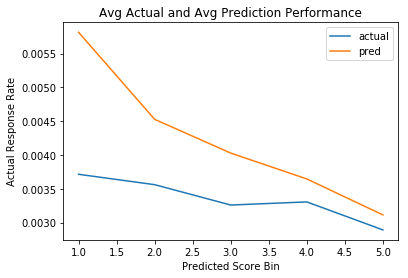

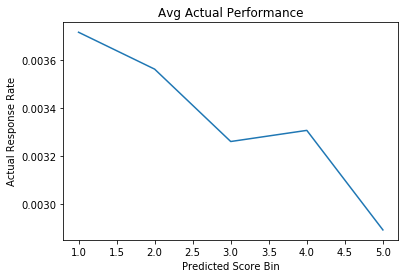

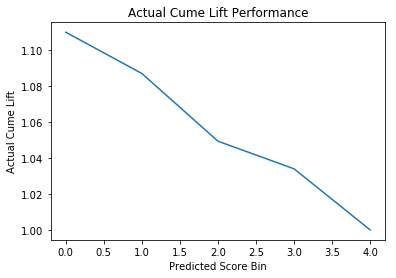

In [13]:
d=np.column_stack([hold_results[:,2],hold_results[:,4]]) #out of fold
eval_model_results_binary(d,5)